<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w3d2_initial/tutorials/W3D2_BasicReinforcementLearning/W3D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 2, Tutorial 1
# Introduction to Reinforcement Learning

__Content creators:__  Feryal Behbahani, Jane Wang, Matthew Sargent, Anoop Kulkarni, Sowmya Parthiban

__Content reviewers:__ Lily Cheng, Roberto Guidotti, Arush Tagade

__Content editors:__ Spiros Chavlis 

__Production editors:__ Spiros Chavlis 

---
#Tutorial Objectives

By the end of the tutorial, you should be able to:

1. Within the RL framework, be able to identify the different components: environment, agent, states, and actions. 
2. Understand the Bellman equation and components involved. 
3. Implement tabular value-based model-free learning (Q-learning and SARSA).
4. Run a DQN agent and experiment with different hyperparameters.
5. Have a high-level understanding of other (nonvalue-based) RL methods.
6. Discuss real-world applications and ethical issues of RL.

In [1]:
#@markdown Tutorial slides

from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/1SspkoRiILE1xGUE0_iRboo-ALqXJVEZCt8IlgWOKgGo/edit?resourcekey=0-gFuj1C_wUqxJ2qPHPTceAQ#slide=id.gdb4fce9ed9_0_289" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

---

# Setup

In [2]:
# Install requirements
!pip install einops --quiet
!pip install dm-acme --quiet
!pip install dm-acme[reverb] --quiet
!pip install dm-acme[tf] --quiet
!pip install dm-acme[envs] --quiet
!pip install dm-env --quiet
!sudo apt-get install -y xvfb ffmpeg --quiet
!pip install imageio --quiet

from IPython.display import clear_output
clear_output()

# Import modules
import gym
import enum
import copy
import time
import acme
import torch
import base64
import dm_env
import random
import IPython
import imageio
import warnings
import itertools
import collections

import numpy as np
import pandas as pd
import sonnet as snt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf

from acme import environment_loop
from acme import specs
from acme import wrappers
from acme.utils import tree_utils
from acme.utils import loggers
from tqdm import tqdm, trange
from torch.autograd import Variable
from torch.distributions import Categorical
from typing import Callable, Optional, Sequence

tf.enable_v2_behavior()
warnings.filterwarnings('ignore')
np.set_printoptions(precision=3, suppress=1)

SEED = 2021

%matplotlib inline

In [3]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

import warnings
warnings.filterwarnings(
    action="ignore", message="This figure includes Axes", category=UserWarning
    )
warnings.filterwarnings(
    action="ignore", message="Calculating RSM", category=UserWarning
    )

In [4]:
#@title Helper Functions
#@markdown Implement helpers for value visualisation  { form-width: "30%" }

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]


def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])


def plot_state_value(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plot_action_values(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))

    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")

  plt.subplot(3, 3, 5)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def smooth(x, window=10):
  return x[:window*(len(x)//window)].reshape(len(x)//window, window).mean(axis=1)


def plot_stats(stats, window=10):
  plt.figure(figsize=(16,4))
  plt.subplot(121)
  xline = range(0, len(stats.episode_lengths), window)
  plt.plot(xline, smooth(stats.episode_lengths, window=window))
  plt.ylabel('Episode Length')
  plt.xlabel('Episode Count')
  plt.subplot(122)
  plt.plot(xline, smooth(stats.episode_rewards, window=window))
  plt.ylabel('Episode Return')
  plt.xlabel('Episode Count')

In [5]:
#@title Set random seed.

#@markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

In [6]:
#@title Set device (GPU or CPU). Execute `set_device()`
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

DEVICE = set_device()
print(f"`DEVICE` selected: {DEVICE}")

GPU is enabled in this notebook.
`DEVICE` selected: cuda


---
#Section 1: Introduction to Reinforcement Learning

Video available at https://youtu.be/BWz3scQN50M


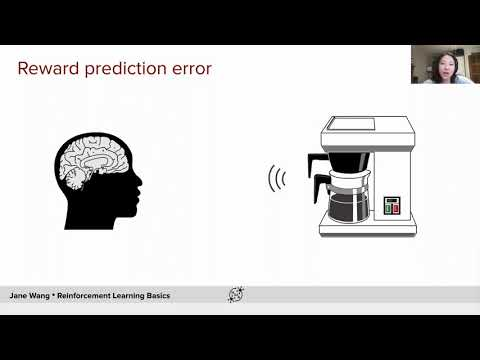

In [7]:
#@title Video 1: Introduction to RL
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="BWz3scQN50M", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---
#Section 2: General Formulation of RL Problems and Gridworlds


Video available at https://youtu.be/vsUS3ULU6EM


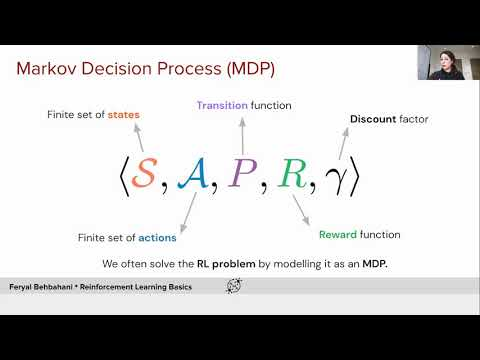

In [8]:
#@title Video 2: General Formulation and MDPs
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="vsUS3ULU6EM", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

The agent interacts with the environment in a loop corresponding to the following diagram. The environment defines a set of <font color='blue'>**actions**</font>  that an agent can take.  The agent takes an action informed by the <font color='redorange'>**observations**</font> it receives, and will get a <font color='green'>**reward**</font> from the environment after each action. The goal in RL is to find an agent whose actions maximize the total accumulation of rewards obtained from the environment. 


<center><img src="https://drive.google.com/uc?id=1KktLm5mdWx1ORotxeYCq1WcQHkXzRT4F" width="500" /></center>




## Section 2.1: The Environment


Video available at https://youtu.be/ASviGzi1jIc


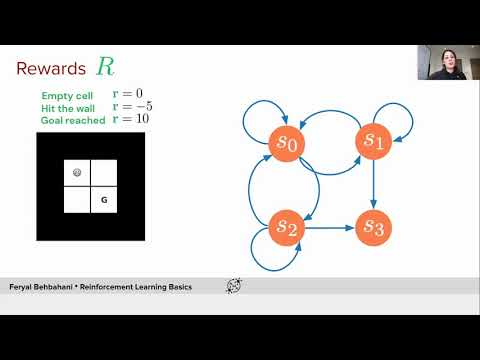

In [9]:
#@title Video 3: Components of MDPs
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ASviGzi1jIc", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


For this practical session we will focus on a **simple grid world** environment,which consists of a 9 x 10 grid of either wall or empty cells, depicted in black and white, respectively. The smiling agent starts from an initial location and needs to navigate to reach the goal square.

<center>
<img src="https://drive.google.com/uc?id=163QdCqrPybJVVO0NhDxpun5O0YZmCnsI" width="500" />
</center>

Below you will find an implementation of this Gridworld as a ```dm_env.Environment```

 


In [10]:
#@title Implement GridWorld { form-width: "30%" }
#@markdown double-click to inspect its contents

class ObservationType(enum.IntEnum):
  STATE_INDEX = enum.auto()
  AGENT_ONEHOT = enum.auto()
  GRID = enum.auto()
  AGENT_GOAL_POS = enum.auto()


class GridWorld(dm_env.Environment):

  def __init__(self,
               layout,
               start_state,
               goal_state=None,
               observation_type=ObservationType.STATE_INDEX,
               discount=0.9,
               penalty_for_walls=-5,
               reward_goal=10,
               max_episode_length=None,
               randomize_goals=False):
    """Build a grid environment.

    Simple gridworld defined by a map layout, a start and a goal state.

    Layout should be a NxN grid, containing:
      * 0: empty
      * -1: wall
      * Any other positive value: value indicates reward; episode will terminate

    Args:
      layout: NxN array of numbers, indicating the layout of the environment.
      start_state: Tuple (y, x) of starting location.
      goal_state: Optional tuple (y, x) of goal location. Will be randomly
        sampled once if None.
      observation_type: Enum observation type to use. One of:
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels.
          First channel contains walls (1 if wall, 0 otherwise), second the
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with
          (agent_y, agent_x, goal_y, goal_x)
      discount: Discounting factor included in all Timesteps.
      penalty_for_walls: Reward added when hitting a wall (should be negative).
      reward_goal: Reward added when finding the goal (should be positive).
      max_episode_length: If set, will terminate an episode after this many
        steps.
      randomize_goals: If true, randomize goal at every episode.
    """
    if observation_type not in ObservationType:
      raise ValueError('observation_type should be a ObservationType instace.')
    self._layout = np.array(layout)
    self._start_state = start_state
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount
    self._penalty_for_walls = penalty_for_walls
    self._reward_goal = reward_goal
    self._observation_type = observation_type
    self._layout_dims = self._layout.shape
    self._max_episode_length = max_episode_length
    self._num_episode_steps = 0
    self._randomize_goals = randomize_goals
    if goal_state is None:
      # Randomly sample goal_state if not provided
      goal_state = self._sample_goal()
    self.goal_state = goal_state

  def _sample_goal(self):
    """Randomly sample reachable non-starting state."""
    # Sample a new goal
    n = 0
    max_tries = 1e5
    while n < max_tries:
      goal_state = tuple(np.random.randint(d) for d in self._layout_dims)
      if goal_state != self._state and self._layout[goal_state] == 0:
        # Reachable state found!
        return goal_state
      n += 1
    raise ValueError('Failed to sample a goal state.')

  @property
  def layout(self):
    return self._layout

  @property
  def number_of_states(self):
    return self._number_of_states

  @property
  def goal_state(self):
    return self._goal_state

  @property
  def start_state(self):
    return self._start_state

  @property
  def state(self):
    return self._state

  def set_state(self, x, y):
    self._state = (y, x)

  @goal_state.setter
  def goal_state(self, new_goal):
    if new_goal == self._state or self._layout[new_goal] < 0:
      raise ValueError('This is not a valid goal!')
    # Zero out any other goal
    self._layout[self._layout > 0] = 0
    # Setup new goal location
    self._layout[new_goal] = self._reward_goal
    self._goal_state = new_goal

  def observation_spec(self):
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      return specs.Array(
          shape=self._layout_dims,
          dtype=np.float32,
          name='observation_agent_onehot')
    elif self._observation_type is ObservationType.GRID:
      return specs.Array(
          shape=self._layout_dims + (3,),
          dtype=np.float32,
          name='observation_grid')
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return specs.Array(
          shape=(4,), dtype=np.float32, name='observation_agent_goal_pos')
    elif self._observation_type is ObservationType.STATE_INDEX:
      return specs.DiscreteArray(
          self._number_of_states, dtype=int, name='observation_state_index')

  def action_spec(self):
    return specs.DiscreteArray(4, dtype=int, name='action')

  def get_obs(self):
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      obs = np.zeros(self._layout.shape, dtype=np.float32)
      # Place agent
      obs[self._state] = 1
      return obs
    elif self._observation_type is ObservationType.GRID:
      obs = np.zeros(self._layout.shape + (3,), dtype=np.float32)
      obs[..., 0] = self._layout < 0
      obs[self._state[0], self._state[1], 1] = 1
      obs[self._goal_state[0], self._goal_state[1], 2] = 1
      return obs
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return np.array(self._state + self._goal_state, dtype=np.float32)
    elif self._observation_type is ObservationType.STATE_INDEX:
      y, x = self._state
      return y * self._layout.shape[1] + x

  def reset(self):
    self._state = self._start_state
    self._num_episode_steps = 0
    if self._randomize_goals:
      self.goal_state = self._sample_goal()
    return dm_env.TimeStep(
        step_type=dm_env.StepType.FIRST,
        reward=None,
        discount=None,
        observation=self.get_obs())

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError(
          'Invalid action: {} is not 0, 1, 2, or 3.'.format(action))

    new_y, new_x = new_state
    step_type = dm_env.StepType.MID
    if self._layout[new_y, new_x] == -1:  # wall
      reward = self._penalty_for_walls
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
      step_type = dm_env.StepType.LAST

    self._state = new_state
    self._num_episode_steps += 1
    if (self._max_episode_length is not None and
        self._num_episode_steps >= self._max_episode_length):
      step_type = dm_env.StepType.LAST
    return dm_env.TimeStep(
        step_type=step_type,
        reward=np.float32(reward),
        discount=discount,
        observation=self.get_obs())

  def plot_grid(self, add_start=True):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout <= -1, interpolation='nearest')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    # Add start/goal
    if add_start:
      plt.text(
          self._start_state[1],
          self._start_state[0],
          r'$\mathbf{S}$',
          fontsize=16,
          ha='center',
          va='center')
    plt.text(
        self._goal_state[1],
        self._goal_state[0],
        r'$\mathbf{G}$',
        fontsize=16,
        ha='center',
        va='center')
    h, w = self._layout.shape
    for y in range(h - 1):
      plt.plot([-0.5, w - 0.5], [y + 0.5, y + 0.5], '-k', lw=2)
    for x in range(w - 1):
      plt.plot([x + 0.5, x + 0.5], [-0.5, h - 0.5], '-k', lw=2)

  def plot_state(self, return_rgb=False):
    self.plot_grid(add_start=False)
    # Add the agent location
    plt.text(
        self._state[1],
        self._state[0],
        u'😃',
        fontname='symbola',
        fontsize=18,
        ha='center',
        va='center',
    )
    if return_rgb:
      fig = plt.gcf()
      plt.axis('tight')
      plt.subplots_adjust(0, 0, 1, 1, 0, 0)
      fig.canvas.draw()
      data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
      w, h = fig.canvas.get_width_height()
      data = data.reshape((h, w, 3))
      plt.close(fig)
      return data

  def plot_policy(self, policy):
    action_names = [
        r'$\uparrow$', r'$\rightarrow$', r'$\downarrow$', r'$\leftarrow$'
    ]
    self.plot_grid()
    plt.title('Policy Visualization')
    h, w = self._layout.shape
    for y in range(h):
      for x in range(w):
        # if ((y, x) != self._start_state) and ((y, x) != self._goal_state):
        if (y, x) != self._goal_state:
          action_name = action_names[policy[y, x]]
          plt.text(x, y, action_name, ha='center', va='center')

  def plot_greedy_policy(self, q):
    greedy_actions = np.argmax(q, axis=2)
    self.plot_policy(greedy_actions)


def build_gridworld_task(task,
                         discount=0.9,
                         penalty_for_walls=-5,
                         observation_type=ObservationType.STATE_INDEX,
                         max_episode_length=200):
  """Construct a particular Gridworld layout with start/goal states.

  Args:
      task: string name of the task to use. One of {'simple', 'obstacle',
        'random_goal'}.
      discount: Discounting factor included in all Timesteps.
      penalty_for_walls: Reward added when hitting a wall (should be negative).
      observation_type: Enum observation type to use. One of:
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels.
          First channel contains walls (1 if wall, 0 otherwise), second the
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with
          (agent_y, agent_x, goal_y, goal_x).
      max_episode_length: If set, will terminate an episode after this many
        steps.
  """
  tasks_specifications = {
      'simple': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          'goal_state': (7, 2)
      },
      'obstacle': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, -1, 0, 0, -1],
              [-1, 0, 0, 0, -1, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          'goal_state': (2, 8)
      },
      'random_goal': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          # 'randomize_goals': True
      },
  }
  return GridWorld(
      discount=discount,
      penalty_for_walls=penalty_for_walls,
      observation_type=observation_type,
      max_episode_length=max_episode_length,
      **tasks_specifications[task])


def setup_environment(environment):
  """Returns the environment and its spec."""

  # Make sure the environment outputs single-precision floats.
  environment = wrappers.SinglePrecisionWrapper(environment)

  # Grab the spec of the environment.
  environment_spec = specs.make_environment_spec(environment)

  return environment, environment_spec


We will use two distinct tabular GridWorlds:
* `simple` where the goal is at the bottom left of the grid, little navigation required.
* `obstacle` where the goal is behind an obstacle the agent must avoid.

You can visualize the grid worlds by running the cell below. 

Note that **S** indicates the start state and **G** indicates the goal. 


Text(0.5, 1.0, 'Obstacle')

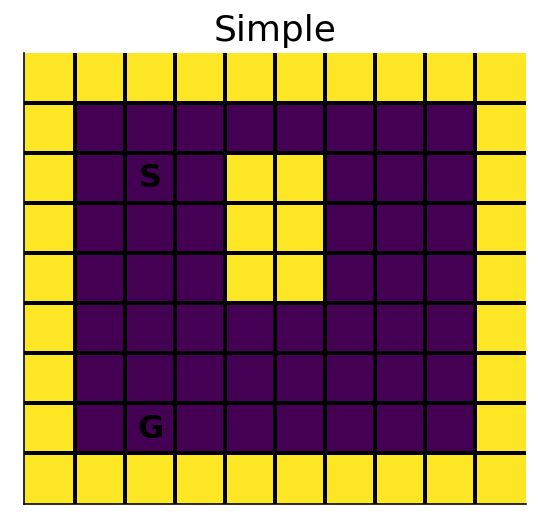

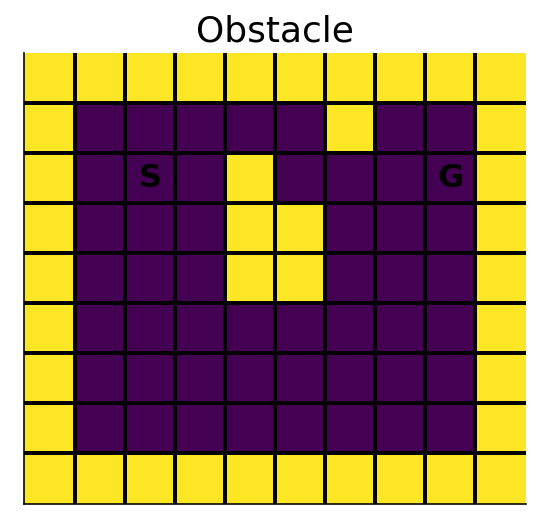

In [11]:
# Visualise GridWorlds

# Instantiate two tabular environments, a simple task, and one that involves
# the avoidance of an obstacle.
simple_grid = build_gridworld_task(
    task='simple', observation_type=ObservationType.GRID)
obstacle_grid = build_gridworld_task(
    task='obstacle', observation_type=ObservationType.GRID)

# Plot them.
simple_grid.plot_grid()
plt.title('Simple')

obstacle_grid.plot_grid()
plt.title('Obstacle')


In this environment, the agent has four possible  <font color='blue'>**actions**</font>: `up`, `right`, `down`, and `left`.  The <font color='green'>**reward**</font> is `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise. The episode ends when the agent reaches the goal, and otherwise continues. The **discount** on continuing steps, is $\gamma = 0.9$. 

Before we start building an agent to interact with this environment, let's first look at the types of objects the environment either returns (e.g. <font color='redorange'>**observations**</font>) or consumes (e.g. <font color='blue'>**actions**</font>). The `environment_spec` will show you the form of the <font color='redorange'>**observations**</font>, <font color='green'>**rewards**</font> and **discounts** that the environment exposes and the form of the <font color='blue'>**actions**</font> that can be taken.


In [12]:
# @title Look at environment_spec { form-width: "30%" }

# Note: setup_environment is implemented in the same cell as GridWorld.
environment, environment_spec = setup_environment(simple_grid)

print('actions:\n', environment_spec.actions, '\n')
print('observations:\n', environment_spec.observations, '\n')
print('rewards:\n', environment_spec.rewards, '\n')
print('discounts:\n', environment_spec.discounts, '\n')

actions:
 DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 

observations:
 Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 

rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward') 

discounts:
 BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 




We first set the environment to its initial location by calling the `reset()` method which returns the first observation. 


findfont: Font family ['symbola'] not found. Falling back to DejaVu Sans.


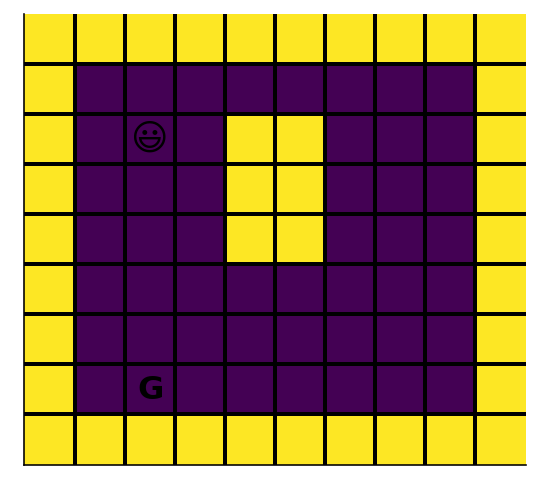

In [13]:
environment.reset()
environment.plot_state()

Now we want to take an action to interact with the environment. We do this by passing a valid action to the `dm_env.Environment.step()` method which returns a `dm_env.TimeStep` namedtuple with fields `(step_type, reward, discount, observation)`.

Let's take an action and visualise the resulting state of the grid-world. (You'll need to rerun the cell if you pick a new action.)

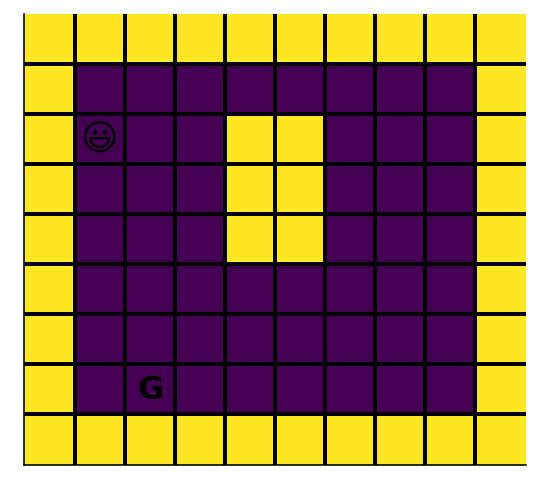

In [14]:
#@title Pick an action and see the state changing
action = "left" #@param ["up", "right", "down", "left"] {type:"string"}

action_int = {'up': 0,
              'right': 1,
              'down': 2,
              'left':3 }
action = int(action_int[action])
timestep = environment.step(action)  # pytype: dm_env.TimeStep
environment.plot_state()

In [15]:
#@title Run loop  { form-width: "30%" }
#@markdown Double-click to inspect the `run_loop` function.


def run_loop(environment,
             agent,
             num_episodes=None,
             num_steps=None,
             logger_time_delta=1.,
             label='training_loop',
             log_loss=False,
             ):
  """Perform the run loop.

  We are following the Acme run loop.

  Run the environment loop for `num_episodes` episodes. Each episode is itself
  a loop which interacts first with the environment to get an observation and
  then give that observation to the agent in order to retrieve an action. Upon
  termination of an episode a new episode will be started. If the number of
  episodes is not given then this will interact with the environment
  infinitely.

  Args:
    environment: dm_env used to generate trajectories.
    agent: acme.Actor for selecting actions in the run loop.
    num_steps: number of episodes to run the loop for. If `None` (default), runs
      without limit.
    num_episodes: number of episodes to run the loop for. If `None` (default),
      runs without limit.
    logger_time_delta: time interval (in seconds) between consecutive logging
      steps.
    label: optional label used at logging steps.
  """
  logger = loggers.TerminalLogger(label=label, time_delta=logger_time_delta)
  iterator = range(num_episodes) if num_episodes else itertools.count()
  all_returns = []

  num_total_steps = 0
  for episode in iterator:
    # Reset any counts and start the environment.
    start_time = time.time()
    episode_steps = 0
    episode_return = 0
    episode_loss = 0

    timestep = environment.reset()

    # Make the first observation.
    agent.observe_first(timestep)

    # Run an episode.
    while not timestep.last():
      # Generate an action from the agent's policy and step the environment.
      action = agent.select_action(timestep.observation)
      timestep = environment.step(action)

      # Have the agent observe the timestep and let the agent update itself.
      agent.observe(action, next_timestep=timestep)
      agent.update()

      # Book-keeping.
      episode_steps += 1
      num_total_steps += 1
      episode_return += timestep.reward

      if log_loss:
        episode_loss += agent.last_loss

      if num_steps is not None and num_total_steps >= num_steps:
        break

    # Collect the results and combine with counts.
    steps_per_second = episode_steps / (time.time() - start_time)
    result = {
        'episode': episode,
        'episode_length': episode_steps,
        'episode_return': episode_return,
    }
    if log_loss:
      result['loss_avg'] = episode_loss/episode_steps

    all_returns.append(episode_return)

    # Log the given results.
    logger.write(result)

    if num_steps is not None and num_total_steps >= num_steps:
      break
  return all_returns

In [16]:
#@title Implement the evaluation loop { form-width: "30%" }
#@markdown Double-click to inspect the `evaluate` function.

def evaluate(environment: dm_env.Environment,
             agent: acme.Actor,
             evaluation_episodes: int):
  frames = []

  for episode in range(evaluation_episodes):
    timestep = environment.reset()
    episode_return = 0
    steps = 0
    while not timestep.last():
      frames.append(environment.plot_state(return_rgb=True))

      action = agent.select_action(timestep.observation)
      timestep = environment.step(action)
      steps += 1
      episode_return += timestep.reward
    print(
        f'Episode {episode} ended with reward {episode_return} in {steps} steps'
    )
  return frames

def display_video(frames: Sequence[np.ndarray],
                  filename: str = 'temp.mp4',
                  frame_rate: int = 12):
  """Save and display video."""
  # Write the frames to a video.
  with imageio.get_writer(filename, fps=frame_rate) as video:
    for frame in frames:
      video.append_data(frame)

  # Read video and display the video.
  video = open(filename, 'rb').read()
  b64_video = base64.b64encode(video)
  video_tag = ('<video  width="320" height="240" controls alt="test" '
               'src="data:video/mp4;base64,{0}">').format(b64_video.decode())
  return IPython.display.HTML(video_tag)

## Section 2.2: The Agent

We will be implementing Tabular & Function Approximation agents. Tabular agents are purely in Python.

All agents will share the same interface from the Acme `Actor`. Here we borrow a figure from Acme to show how this interaction occurs:


Video available at https://youtu.be/oW1cqiSP8J8


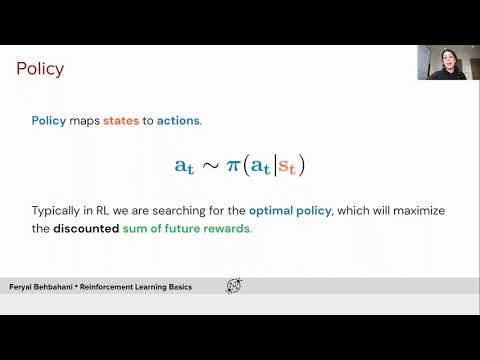

In [17]:
#@title Video 4: More MDP components
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="oW1cqiSP8J8", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

### Agent interface


<center><img src="https://drive.google.com/uc?id=1T7FTpA9RgDYFkciDFZK4brNyURZN_ZGp" width="500" /></center>

Each agent implements the following functions:

```python
class Agent(acme.Actor):
  def __init__(self, number_of_actions, number_of_states, ...):
    """Provides the agent the number of actions and number of states."""

  def select_action(self, observation):
    """Generates actions from observations."""

  def observe_first(self, timestep):
    """Records the initial timestep in a trajectory."""
  
  def observe(self, action, next_timestep):
    """Records the transition which occurred from taking an action."""

  def update(self):
    """Updates the agent's internals to potentially change its behavior."""
```

Remarks on the `observe()` function:

1. In the last method, the `next_timestep` provides the `reward`, `discount`, and `observation` that resulted from selecting `action`.

2. The `next_timestep.step_type` will be either `MID` or `LAST` and should be used to determine whether this is the last observation in the episode.

3. The `next_timestep.step_type` cannot be `FIRST`; such a timestep should only ever be given to `observe_first()`.


### Coding Exercise 2.1: Random Agent

Below is a partially complete implemention of an agent that follows a random policy. Fill in the ```select_action``` method.

The ```select_action``` method should return a random **integer** between 0 and ```self._num_actions``` (not a tensor or an array!)

In [18]:
class RandomAgent(acme.Actor):

  def __init__(self, environment_spec):
    """Gets the number of available actions from the environment spec."""
    self._num_actions = environment_spec.actions.num_values

  def select_action(self, observation):
    """Selects an action uniformly at random."""
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Student exercise: complete the select action method")
    #################################################
    # TODO return a random integer
    action = ...
    return action

  def observe_first(self, timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def observe(self, action, next_timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def update(self):
    """Does not update as the RandomAgent does not learn from data."""
    pass

In [19]:
#to_remove solution
class RandomAgent(acme.Actor):

  def __init__(self, environment_spec):
    """Gets the number of available actions from the environment spec."""
    self._num_actions = environment_spec.actions.num_values

  def select_action(self, observation):
    """Selects an action uniformly at random."""
    # TODO return a random integer
    action = np.random.randint(self._num_actions)
    return action

  def observe_first(self, timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def observe(self, action, next_timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def update(self):
    """Does not update as the RandomAgent does not learn from data."""
    pass

In [20]:
#@title Visualisation { form-width: "30%" }

# Create the agent by giving it the action space specification.
agent = RandomAgent(environment_spec)

# Run the agent in the evaluation loop, which returns the frames.
frames = evaluate(environment, agent, evaluation_episodes=1)

# Visualize the random agent's episode.
display_video(frames)

Episode 0 ended with reward -50.0 in 125 steps


---
#Section 3: The Bellman Equation

Video available at https://youtu.be/cLCoNBmYUns


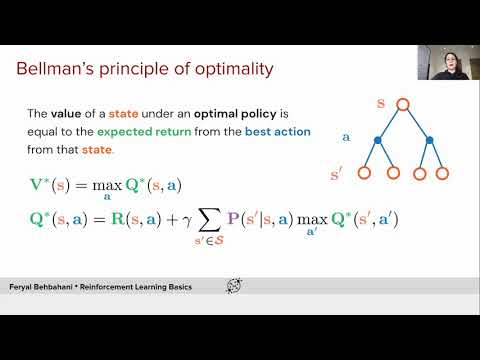

In [21]:
#@title Video 5: The Bellman Equation
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="cLCoNBmYUns", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video



In this tutorial we focus mainly on <font color='green'>**value based methods**</font>, where agents maintain a value for all state-action pairs and use those estimates to choose actions that maximize that <font color='green'>**value**</font> (instead of maintaining a policy directly, like in <font color='blue'>**policy gradient methods**</font>). 

We represent the <font color='green'>**action-value function**</font> (otherwise known as $\color{green}Q$-function associated with following/employing a policy $\pi$ in a given MDP as:

$$ \color{green}Q^{\color{blue}{\pi}}(\color{red}{s},\color{blue}{a}) = \mathbb{E}_{\tau \sim P^{\color{blue}{\pi}}} \left[ \sum_t \gamma^t \color{green}{r_t}| s_0=\color{red}s,a_0=\color{blue}{a} \right]$$

where $\tau = \{\color{red}{s_0}, \color{blue}{a_0}, \color{green}{r_0}, \color{red}{s_1}, \color{blue}{a_1}, \color{green}{r_1}, \cdots \}$


Recall that efficient value estimations are based on the famous **_Bellman Expectation Equation_**:

$$ \color{green}Q^\color{blue}{\pi}(\color{red}{s},\color{blue}{a}) =    \sum_{\color{red}{s'}\in \color{red}{\mathcal{S}}} 
\color{purple}P(\color{red}{s'} |\color{red}{s},\color{blue}{a})
\left(
  \color{green}{R}(\color{red}{s},\color{blue}{a}, \color{red}{s'}) 
  + \gamma \color{green}V^\color{blue}{\pi}(\color{red}{s'}) 
  \right)
$$

where $\color{green}V^\color{blue}{\pi}$ is the expected $\color{green}Q^\color{blue}{\pi}$ value for a particular state, i.e. $\color{green}V^\color{blue}{\pi}(\color{red}{s}) = \sum_{\color{blue}{a} \in \color{blue}{\mathcal{A}}} \color{blue}{\pi}(\color{blue}{a} |\color{red}{s}) \color{green}Q^\color{blue}{\pi}(\color{red}{s},\color{blue}{a})$.


---
# Section 4: Policy Evaluation

Video available at https://youtu.be/HAxR4SuaZs4


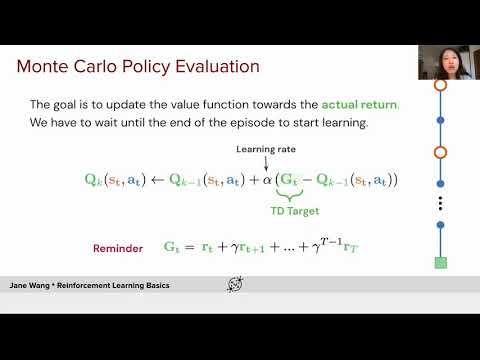

In [22]:
#@title Video 6: Policy Evaluation
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="HAxR4SuaZs4", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


Tabular agents implement a function `q_values()` returning a matrix of Q values
of shape: (`number_of_states`, `number_of_actions`)

In this section, we will implement a `PolicyEvalAgent` as an ACME actor: given an `evaluation_policy` and a `behaviour_policy`, it will use the `behaviour_policy` to choose actions, and it will use the corresponding trajectory data to evaluate the `evaluation_policy` (i.e. compute the Q-values as if you were following the `evaluation_policy`).

In [23]:
# Uniform random policy
def random_policy(q):
  return np.random.randint(4)

### Coding Exercise 4.1 Policy Evaluation Agent

In [24]:
class PolicyEvalAgent(acme.Actor):

  def __init__(self, number_of_states, number_of_actions, evaluated_policy,
               behaviour_policy=random_policy, step_size=0.1):

    self._state = None
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._evaluated_policy = evaluated_policy
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Initialize your Q-values!")
    #################################################
    # (this is a table of state and action pairs)
    # Note: this can be random, but the code was tested w/ zero-initialization
    self._q = ...
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    # return the Q values
    return ...

  def select_action(self, observation):
    # Select an action
    return ...

  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    # Compute TD-Error.
    self._td_error = ...

  def update(self):
    # Updates
    s = self._state
    a = self._action
    # Q-value table update.
    self._q[s, a] += ...
    # Update the state
    self._state = ...

In [25]:
#to_remove solution
class PolicyEvalAgent(acme.Actor):

  def __init__(self, number_of_states, number_of_actions, evaluated_policy,
               behaviour_policy=random_policy, step_size=0.1):

    self._state = None
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._evaluated_policy = evaluated_policy
    # (this is a table of state and action pairs)
    # Note: this can be random, but the code was tested w/ zero-initialization
    self._q = np.zeros((number_of_states, number_of_actions))
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    # return the Q values
    return self._q

  def select_action(self, observation):
    # Select an action
    return self._behaviour_policy(self._q[observation])

  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    # Compute TD-Error.
    self._td_error = r + g * self._q[next_s, next_a] - self._q[s, a]

  def update(self):
    # Updates
    s = self._state
    a = self._action
    # Q-value table update.
    self._q[s, a] += self._step_size * self._td_error
    # Update the state
    self._state = self._next_state

---
# Section 5: Tabular Value-Based Model-Free Learning

Video available at https://youtu.be/Y4TweUYnexU


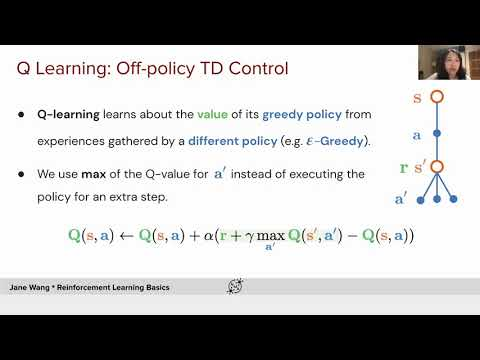

In [26]:
#@title Video 7: Model-Free Learning
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Y4TweUYnexU", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Section 5.1: On-policy control: SARSA Agent
In this section, we are focusing on control RL algorithms, which perform the **evaluation** and **improvement** of the policy synchronously. That is, the policy that is being evaluated improves as the agent is using it to interact with the environent.


The first algorithm we are going to be looking at is SARSA. This is an **on-policy algorithm** -- i.e: the data collection is done by leveraging the policy we're trying to optimize. 

As discussed during lectures, a greedy policy with respect to a given $\color{Green}Q$ fails to explore the environment as needed; we will use instead an $\epsilon$-greedy policy with respect to $\color{Green}Q$.

### SARSA Algorithm

**Input:**
- $\epsilon \in (0, 1)$ the probability of taking a random action , and
- $\alpha > 0$ the step size, also known as learning rate.

**Initialize:** $\color{green}Q(\color{red}{s}, \color{blue}{a})$ for all $\color{red}{s}$ ∈ $\mathcal{\color{red}S}$ and $\color{blue}a$ ∈ $\mathcal{\color{blue}A}$

**Loop forever:**

1. Get $\color{red}s \gets{}$current (non-terminal) state
 
2. Select $\color{blue}a \gets{} \text{epsilon_greedy}(\color{green}Q(\color{red}s, \cdot))$
 
3. Step in the environment by passing the selected action $\color{blue}a$

4. Observe resulting reward $\color{green}r$, discount $\gamma$, and state $\color{red}{s'}$

5. Compute TD error: $\Delta \color{green}Q \gets 
\color{green}r + \gamma \color{green}Q(\color{red}{s'}, \color{blue}{a'}) − \color{green}Q(\color{red}s, \color{blue}a)$, <br> where $\color{blue}{a'} \gets \text{epsilon_greedy}(\color{green}Q(\color{red}{s'}, \cdot))$

5. Update $\color{green}Q(\color{red}s, \color{blue}a) \gets \color{green}Q(\color{red}s, \color{blue}a) + \alpha \Delta \color{green}Q$


### Coding Exercise 5.1: Implement SARSA
Below you will find incomplete code for sampling from an $\epsilon$-greedy policy, and for implementing an agent that learns values according to the SARSA algorithm.




In [27]:
def epsilon_greedy(
    q_values_at_s: np.ndarray,  # Q-values in state s: Q(s, :).
    epsilon: float = 0.1  # Probability of taking a random action.
    ):
  """Return an epsilon-greedy action sample."""
  #################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your implementation
  raise NotImplementedError("Student exercise: complete epsilon greedy policy function")
  #################################################
  # TODO return the action greedy to Q values
  if ...:
    # Greedy: Pick action with the largest Q-value.
    action = ...
  else:
    # Get the number of actions from the size of the given vector of Q-values.
    num_actions = np.array(q_values_at_s).shape[-1]
    # TODO else return a random action
    action = ...

  return action

In [28]:
#to_remove solution
def epsilon_greedy(
    q_values_at_s: np.ndarray,  # Q-values in state s: Q(s, :).
    epsilon: float = 0.1  # Probability of taking a random action.
    ):
  """Return an epsilon-greedy action sample."""
  # TODO return the action greedy to Q values
  if epsilon < np.random.random():
    # Greedy: Pick action with the largest Q-value.
    action = np.argmax(q_values_at_s)
  else:
    # Get the number of actions from the size of the given vector of Q-values.
    num_actions = np.array(q_values_at_s).shape[-1]
    # TODO else return a random action
    action = np.random.randint(num_actions)

  return action

### Coding Exercise 5.2: Run your SARSA agent on the `obstacle` environment

This environment is similar to the Cliff-walking example from [Sutton & Barto](http://incompleteideas.net/book/RLbook2018.pdf) and allows us to see the different policies learned by on-policy vs off-policy methods. Try varying the number of steps.

In [29]:
class SarsaAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               epsilon: float,
               step_size: float = 0.1
               ):

    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size
    self._epsilon = epsilon

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return epsilon_greedy(self._q[observation], self._epsilon)

  def observe_first(self, timestep):
    # Set current state.
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    # Compute the action that would be taken from the next state.
    next_a = self.select_action(next_s)
    # Compute the on-policy Q-value update.
    self._action = a
    self._next_state = next_s
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Student exercise: complete the on-policy Q-value update")
    #################################################
    # TODO complete the line below to compute the temporal difference error
    self._td_error = r + g * self._q[next_s, next_a] - self._q[s, a]

  def update(self):
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Student exercise: complete value update")
    #################################################
    # Update the Q-value table value at (s, a).
    # TODO: Update the Q-value table value at (s, a).
    self._q[s, a] += ...
    # Update the current state.
    self._state = self._next_state

In [30]:
#to_remove solution
class SarsaAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               epsilon: float,
               step_size: float = 0.1
               ):

    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size
    self._epsilon = epsilon

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return epsilon_greedy(self._q[observation], self._epsilon)

  def observe_first(self, timestep):
    # Set current state.
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    # Compute the action that would be taken from the next state.
    next_a = self.select_action(next_s)
    # Compute the on-policy Q-value update.
    self._action = a
    self._next_state = next_s
    # TODO complete the line below to compute the temporal difference error
    self._td_error = r + g * self._q[next_s, next_a] - self._q[s, a]

  def update(self):
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action
    # Update the Q-value table value at (s, a).
    # TODO: Update the Q-value table value at (s, a).
    self._q[s, a] += self._step_size * self._td_error
    # Update the current state.
    self._state = self._next_state

AFTER 100,000 STEPS ...


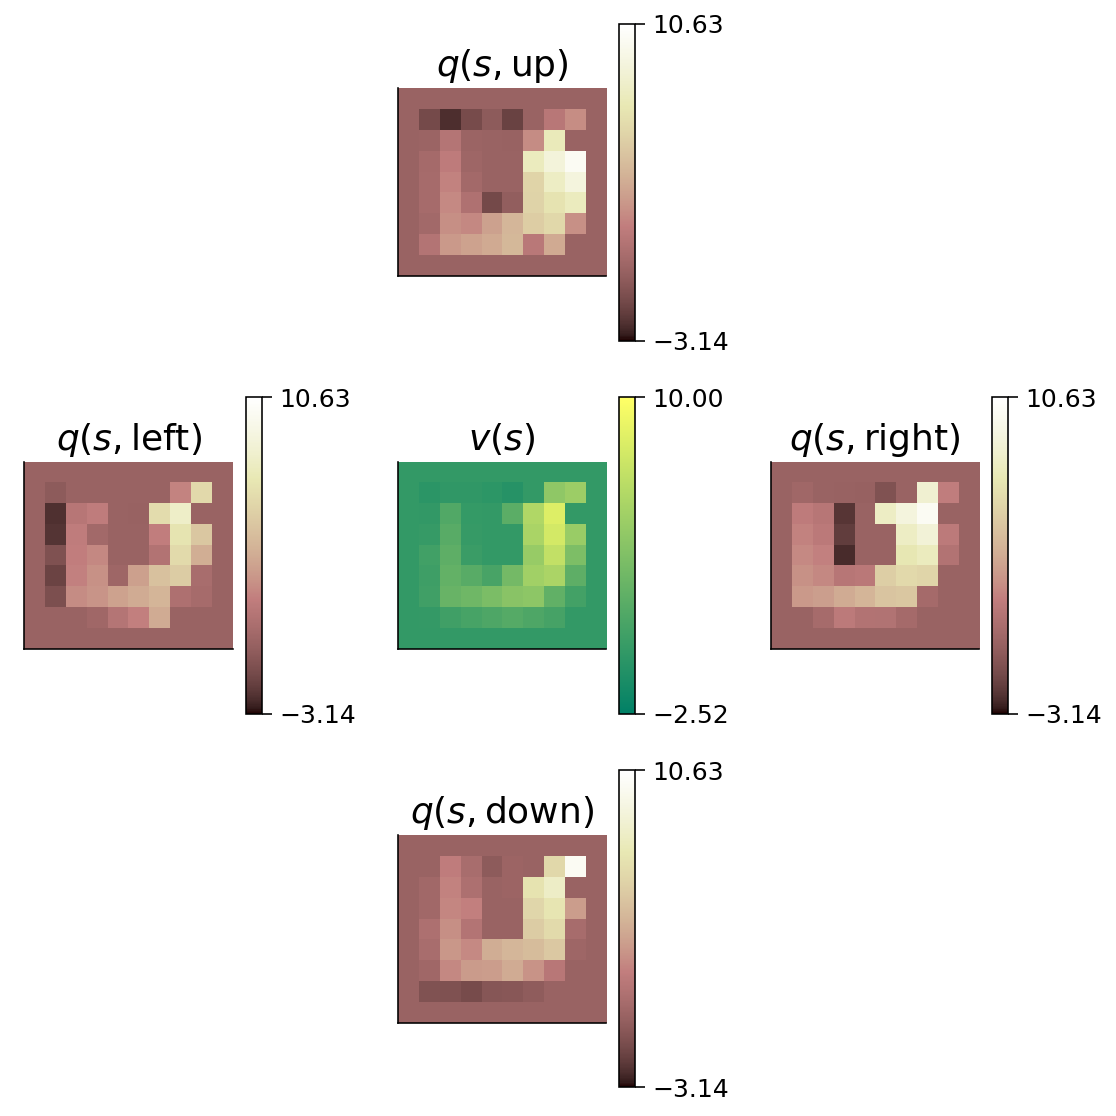

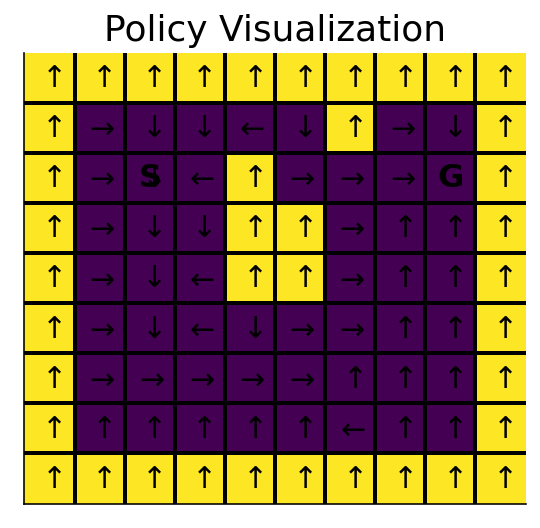

In [31]:
#@title Run SARSA agent
num_steps = 1e5 #@param {type:"number"}
num_steps = int(num_steps)

# Create the environment.
grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

# Create the agent.
agent = SarsaAgent(environment_spec, epsilon=0.1, step_size=0.1)

# Run the experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)
print('AFTER {0:,} STEPS ...'.format(num_steps))

# Get the Q-values and reshape them to recover grid-like structure of states.
q_values = agent.q_values
grid_shape = grid.layout.shape
q_values = q_values.reshape([*grid_shape, -1])

# Visualize the value and Q-value tables.
plot_action_values(q_values, epsilon=1.)

# Visualize the greedy policy.
environment.plot_greedy_policy(q_values)

##Section 5.2 Off-policy control: Q-learning Agent
Reminder: $\color{green}Q$-learning is a very powerful and general algorithm, that enables control (figuring out the optimal policy/value function) both on and off-policy.

**Initialize** $\color{green}Q(\color{red}{s}, \color{blue}{a})$ for all $\color{red}{s} \in \color{red}{\mathcal{S}}$ and $\color{blue}{a} \in \color{blue}{\mathcal{A}}$

**Loop forever**:

1. Get $\color{red}{s} \gets{}$current (non-terminal) state
 
2. Select $\color{blue}{a} \gets{} \text{behaviour_policy}(\color{red}{s})$
 
3. Step in the environment by passing the selected action $\color{blue}{a}$

4. Observe resulting reward $\color{green}{r}$, discount $\gamma$, and state, $\color{red}{s'}$

5. Compute the TD error: $\Delta \color{green}Q \gets \color{green}{r} + \gamma \color{green}Q(\color{red}{s'}, \color{blue}{a'}) − \color{green}Q(\color{red}{s}, \color{blue}{a})$, <br>
where $\color{blue}{a'} \gets \arg\max_{\color{blue}{\mathcal A}} \color{green}Q(\color{red}{s'}, \cdot)$

6. Update $\color{green}Q(\color{red}{s}, \color{blue}{a}) \gets \color{green}Q(\color{red}{s}, \color{blue}{a}) + \alpha \Delta \color{green}Q$

Notice that the actions $\color{blue}{a}$ and $\color{blue}{a'}$ are not selected using the same policy, hence this algorithm being **off-policy**.

### Coding Exercise 5.3: Implement Q-Learning


In [32]:
QValues = np.ndarray
Action = int
# A value-based policy takes the Q-values at a state and returns an action.
ValueBasedPolicy = Callable[[QValues], Action]


class QLearningAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               behaviour_policy: ValueBasedPolicy,
               step_size: float = 0.1):

    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size

    # Store behavior policy.
    self._behaviour_policy = behaviour_policy

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])

  def observe_first(self, timestep):
    # Set current state.
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation

    # Compute the TD error.
    self._action = a
    self._next_state = next_s
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Student exercise: complete the off-policy Q-value update")
    #################################################
    # TODO complete the line below to compute the temporal difference error
    self._td_error = ...

  def update(self):
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Student exercise: complete value update")
    #################################################
    # Update the Q-value table value at (s, a).
    # TODO: Update the Q-value table value at (s, a).
    self._q[...] += ...
    # Update the current state.
    self._state = self._next_state

In [33]:
#to_remove solution
QValues = np.ndarray
Action = int
# A value-based policy takes the Q-values at a state and returns an action.
ValueBasedPolicy = Callable[[QValues], Action]


class QLearningAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               behaviour_policy: ValueBasedPolicy,
               step_size: float = 0.1):

    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size

    # Store behavior policy.
    self._behaviour_policy = behaviour_policy

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])

  def observe_first(self, timestep):
    # Set current state.
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation

    # Compute the TD error.
    self._action = a
    self._next_state = next_s
    # TODO complete the line below to compute the temporal difference error
    self._td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]

  def update(self):
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action
    # Update the Q-value table value at (s, a).
    # TODO: Update the Q-value table value at (s, a).
    self._q[s, a] += self._step_size * self._td_error
    # Update the current state.
    self._state = self._next_state

### Run your Q-learning agent on the `obstacle` environment


AFTER 100,000 STEPS ...


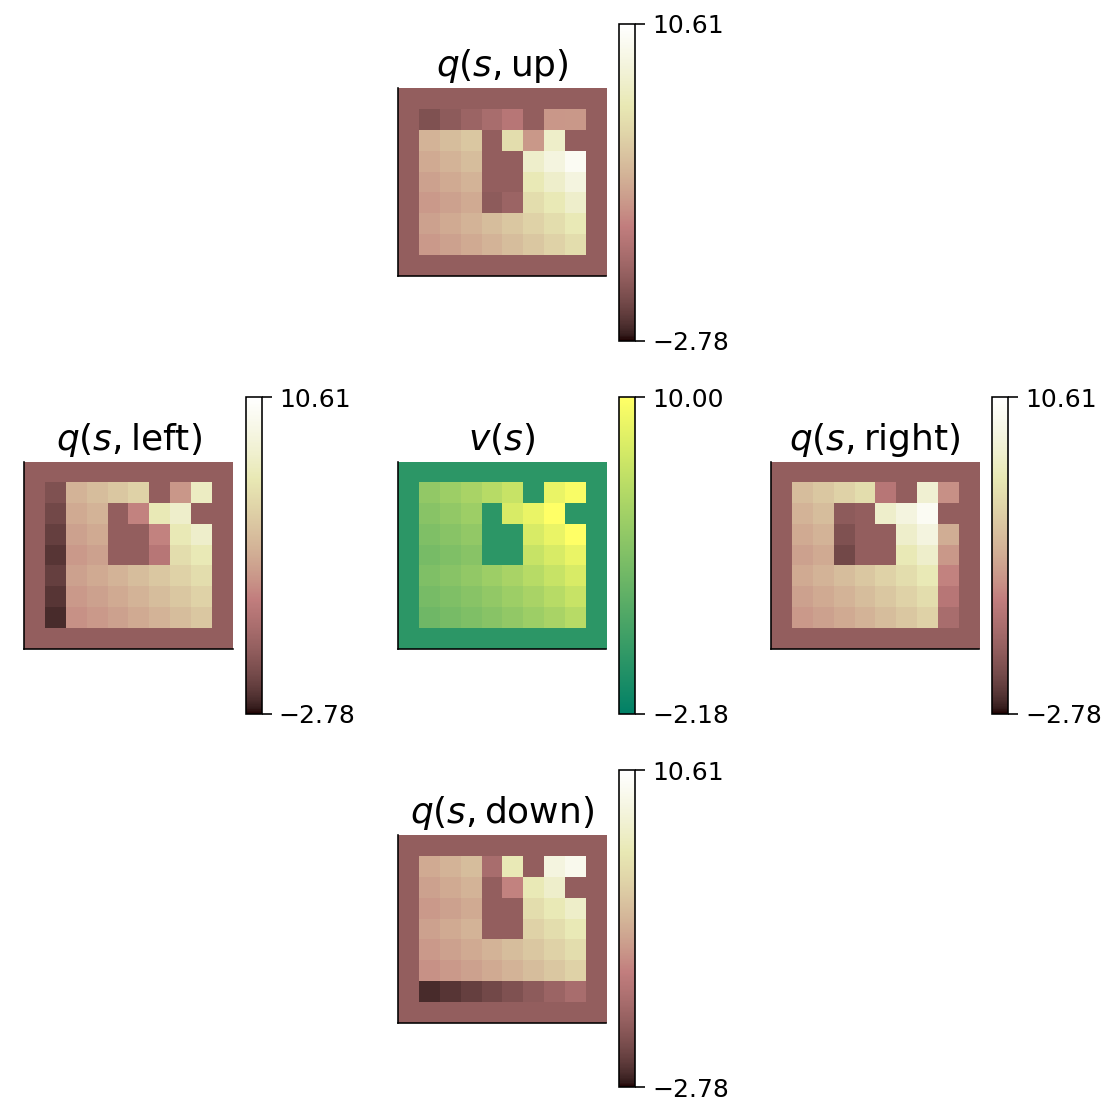

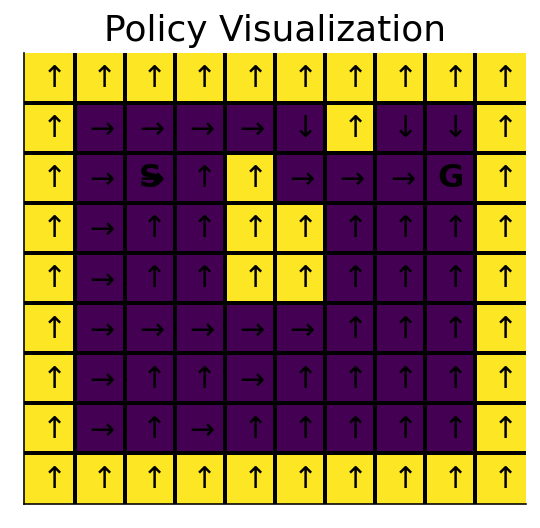

In [34]:
#@title Run your Q-learning
epsilon = 1.  #@param {type:"number"}
num_steps = 1e5  #@param {type:"number"}
num_steps = int(num_steps)

# environment
grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = QLearningAgent(environment_spec, behavior_policy, step_size=0.1)

# run experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

# get the q-values
q = agent.q_values.reshape(grid.layout.shape + (4,))

# visualize value functions
print('AFTER {:,} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=0)

# visualise the greedy policy
grid.plot_greedy_policy(q)

### Experiment with different levels of greediness
* The default was $\epsilon=1.$, what does this correspond to?
* Try also $\epsilon =0.1, 0.5$. What do you observe? Does the behaviour policy affect the training in any way?

AFTER 100,000 STEPS ...


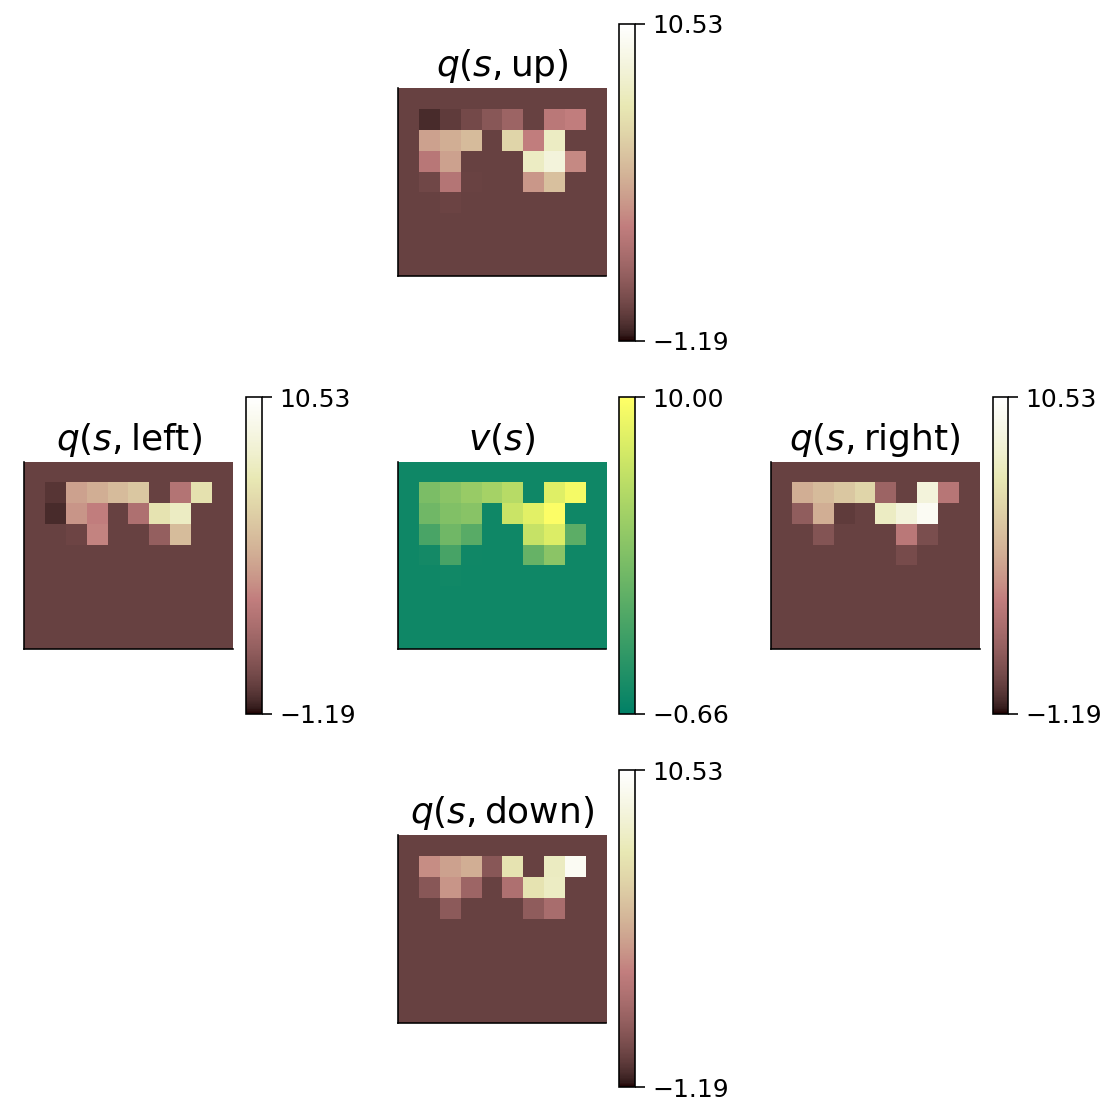

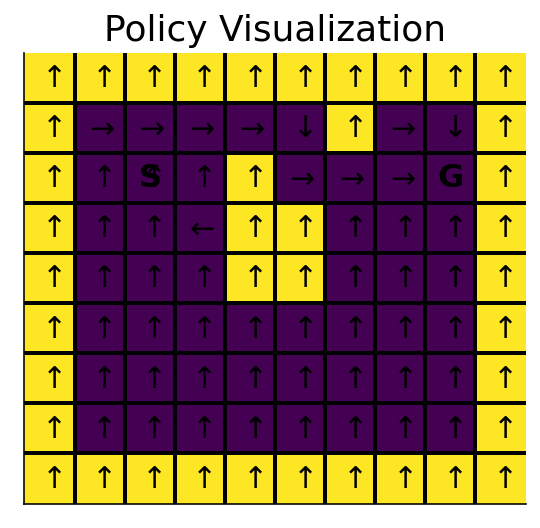

In [35]:
#@title Run the cell
epsilon = 0.1  #@param {type:"number"}
num_steps = 1e5  #@param {type:"number"}
num_steps = int(num_steps)

# environment
grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = QLearningAgent(environment_spec, behavior_policy, step_size=0.1)

# run experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

# get the q-values
q = agent.q_values.reshape(grid.layout.shape + (4,))

# visualize value functions
print('AFTER {:,} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=epsilon)

# visualise the greedy policy
grid.plot_greedy_policy(q)

<center>
<img src="https://drive.google.com/uc?id=1XIj68U3eB1bKYfIEHAcVbfwobmMYQQ4X" width="500" />
</center>

So far we only considered look-up tables for value-functions. In all previous cases every state and action pair $(\color{red}{s}, \color{blue}{a})$, had an entry in our $\color{green}Q$-table. Again, this is possible in this environment as the number of states is equal to the number of cells in the grid. But this is not scalable to situations where, say, the goal location changes or the obstacles are in different locations at every episode (consider how big the table could be in this situation?).

An example (not covered in this tutorial) is ATARI from pixels, where the number of possible frames an agent can see is exponential in the number of pixels on the screen.

<center><img width="200" alt="portfolio_view" src="https://miro.medium.com/max/1760/1*XyIpmXXAjbXerDzmGQL1yA.gif"></center>

But what we **really** want is just to be able to *compute* the Q-value, when fed with a particular $(\color{red}{s}, \color{blue}{a})$ pair. So if we had a way to get a function to do this work instead of keeping a big table, we'd get around this problem.

To address this, we can use **function approximation** as a way to generalize Q-values over some representation of the very large state space, and **train** them to output the values they should. In this section, we will explore $\color{green}Q$-learning with function approximation, which (although it has been theoretically proven to diverge for some degenerate MDPs) can yield impressive results in very large environments. In particular, we will look at [Neural Fitted Q (NFQ) Iteration](http://ml.informatik.uni-freiburg.de/former/_media/publications/rieecml05.pdf) and [Deep Q-Networks (DQN)](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf).



---
# Section 6: Function Approximation

Video available at https://youtu.be/3cLUfsRDNjU


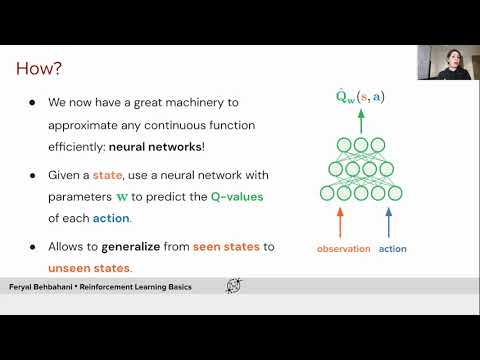

In [36]:
#@title Video 8: Function approximation
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="3cLUfsRDNjU", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

##Section 6.1 Replay Buffers
An important property of off-policy methods like $\color{green}Q$-learning is that they involve two policies: one for exploration and one that is being optimized (via the $\color{green}Q$-function updates). This means that we can generate data from the **behavior** policy and insert that data into some form of data storage---usually referred to as **replay**.

In order to optimize the $\color{green}Q$-function we can then sample data from the replay <font color='purple'>**dataset**</font> and use that data to perform an update. An illustration of this learning loop is shown below.

<center><img src="https://drive.google.com/uc?id=1ivTQBHWkYi_J9vWwXFd2sSWg5f2TB5T-" width="400" /></center> 

In the next cell we will show how to implement a simple replay buffer. This can be as simple as a python list containing transition data. In more complicated scenarios we might want to have a more performance-tuned variant, we might have to be more concerned about how large replay is and what to do when its full, and we might want to sample from replay in different ways. But a simple python list can go a surprisingly long way.

In [37]:
# Simple replay buffer

# Create a convenient container for the SARS tuples required by deep RL agents.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])

class ReplayBuffer(object):
  """A simple Python replay buffer."""

  def __init__(self, capacity: int = None):
    self.buffer = collections.deque(maxlen=capacity)
    self._prev_state = None

  def add_first(self, initial_timestep: dm_env.TimeStep):
    self._prev_state = initial_timestep.observation

  def add(self, action: int, timestep: dm_env.TimeStep):
    transition = Transitions(
        state=self._prev_state,
        action=action,
        reward=timestep.reward,
        discount=timestep.discount,
        next_state=timestep.observation,
    )
    self.buffer.append(transition)
    self._prev_state = timestep.observation

  def sample(self, batch_size: int) -> Transitions:
    # Sample a random batch of Transitions as a list.
    batch_as_list = random.sample(self.buffer, batch_size)

    # Convert the list of `batch_size` Transitions into a single Transitions
    # object where each field has `batch_size` stacked fields.
    return tree_utils.stack_sequence_fields(batch_as_list)

  def flush(self) -> Transitions:
    entire_buffer = tree_utils.stack_sequence_fields(self.buffer)
    self.buffer.clear()
    return entire_buffer

  def is_ready(self, batch_size: int) -> bool:
    return batch_size <= len(self.buffer)

## Section 6.2: NFQ Agent
[Neural Fitted Q Iteration](http://ml.informatik.uni-freiburg.de/former/_media/publications/rieecml05.pdf) was one of the first papers to demonstrate how to leverage recent advances in Deep Learning to approximate the Q-value by a neural network.$^1$
In other words, the value $\color{green}Q(\color{red}{s}, \color{blue}{a})$ are approximated by the output of a neural network $\color{green}{Q_w}(\color{red}{s}, \color{blue}{a})$ for each possible action $\color{blue}{a} \in \color{blue}{\mathcal{A}}$.$^2$

When introducing function approximations, and neural networks in particular, we need to have a loss to optimize. But looking back at the tabular setting above, you can see that we already have some notion of error: the **TD error**.

By training our neural network to output values such that the *TD error is minimized*, we will also satisfy the Bellman Optimality Equation, which is a good sufficient condition to enforce, to obtain an optimal policy.
Thanks to automatic differentiation, we can just write the TD error as a loss, e.g. with an $\ell^2$ loss, but others would work too:

$$L(\color{green}w) = \mathbb{E}\left[ \left( \color{green}{r} + \gamma \max_\color{blue}{a'} \color{green}{Q_w}(\color{red}{s'}, \color{blue}{a'}) − \color{green}{Q_w}(\color{red}{s}, \color{blue}{a})  \right)^2\right].$$

Then we can compute the gradient with respect to the parameters of the neural network and improve our Q-value approximation incrementally.

NFQ builds on $\color{green}Q$-learning, but if one were to update the Q-values online directly, the training can be unstable and very slow.
Instead, NFQ uses a replay buffer, similar to what you just implemented above, to update the Q-value in a batched setting.

When it was introduced, it also was entirely off-policy using a uniformly random policy to collect data, which was prone to instability when applied to more complex environments (e.g. when the input are pixels or the tasks are longer and more complicated).
But it is a good stepping stone to the more complex agents used today. Here, we will look at a slightly different and modernised implementation of NFQ.

Below you will find an incomplete NFQ agent that takes in observations from a gridworld. Instead of receiving a tabular state, it receives an observation in the form of its (x,y) coordinates in the gridworld, and the (x,y) coordinates of the goal.
<br />

---

<sub>$^1$ If you read the NFQ paper, they use a "control" notation, where there is a "cost to minimize", instead of "rewards to maximize", so don't be surprised if signs/max/min do not correspond.</sub>

<sub>$^2$ We could feed it $\color{blue}{a}$ as well and ask $Q_w$ for a single scalar value, but given we have a fixed number of actions and we usually need to take an $argmax$ over them, it's easiest to just output them all in one pass.</sub>


Video available at https://youtu.be/LoiEDZzRJPQ


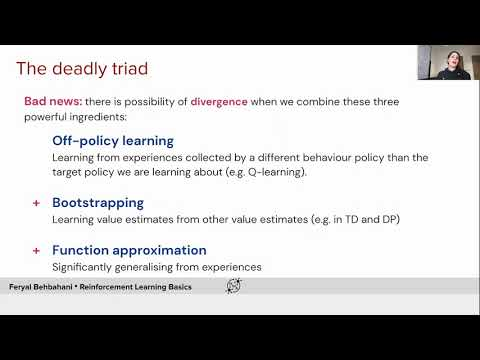

In [38]:
#@title Video 9: Function approximation: Loss and Updates
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="LoiEDZzRJPQ", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

### Coding Exercise 6.1: Implement NFQ 

In [39]:
# Create a convenient container for the SARS tuples required by NFQ.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])


class NeuralFittedQAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               q_network: nn.Module,
               replay_capacity: int = 100_000,
               epsilon: float = 0.1,
               batch_size: int = 1,
               learning_rate: float = 3e-4):

    # Store agent hyperparameters and network.
    self._num_actions = environment_spec.actions.num_values
    self._epsilon = epsilon
    self._batch_size = batch_size
    self._q_network = q_network

    # Container for the computed loss (see run_loop implementation above).
    self.last_loss = 0.0

    # Create the replay buffer.
    self._replay_buffer = ReplayBuffer(replay_capacity)

    # Setup optimizer that will train the network to minimize the loss.
    self._optimizer = torch.optim.Adam(self._q_network.parameters(),lr = learning_rate)
    self._loss_fn = nn.MSELoss()

  def select_action(self, observation):
    # Compute Q-values.
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))  # Adds batch dimension.
    q_values = q_values.squeeze(0)   # Removes batch dimension

    # Select epsilon-greedy action.
    if self._epsilon < torch.rand(1):
      action = q_values.argmax(axis=-1)
    else:
      action = torch.randint(low=0, high=self._num_actions , size=(1,), dtype=torch.int64)
    return action

  def q_values(self, observation):
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))
    return q_values.squeeze(0).detach()

  def update(self):

    if not self._replay_buffer.is_ready(self._batch_size):
      # If the replay buffer is not ready to sample from, do nothing.
      return

    # Sample a minibatch of transitions from experience replay.
    transitions = self._replay_buffer.sample(self._batch_size)

    # Note: each of these tensors will be of shape [batch_size, ...].
    s = torch.tensor(transitions.state)
    a = torch.tensor(transitions.action,dtype=torch.int64)
    r = torch.tensor(transitions.reward)
    d = torch.tensor(transitions.discount)
    next_s = torch.tensor(transitions.next_state)

    # Compute the Q-values at next states in the transitions.
    with torch.no_grad():
      q_next_s = self._q_network(next_s)  # Shape [batch_size, num_actions].
      max_q_next_s = q_next_s.max(axis=-1)[0]
      # Compute the TD error and then the losses.
      target_q_value = r + d * max_q_next_s

    # Compute the Q-values at original state.
    q_s = self._q_network(s)

    # Gather the Q-value corresponding to each action in the batch.
    q_s_a = q_s.gather(1, a.view(-1,1)).squeeze(0)
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Student exercise: complete the NFQ Agent")
    #################################################
    # TODO Average the squared TD errors over the entire batch (axis=0).
    loss = ...

    # Compute the gradients of the loss with respect to the q_network variables.
    self._optimizer.zero_grad()

    loss.backward()
    # Apply the gradient update.
    self._optimizer.step()

    # Store the loss for logging purposes (see run_loop implementation above).
    self.last_loss = loss.detach().numpy()

  def observe_first(self, timestep: dm_env.TimeStep):
    self._replay_buffer.add_first(timestep)

  def observe(self, action: int, next_timestep: dm_env.TimeStep):
    self._replay_buffer.add(action, next_timestep)

In [40]:
#to_remove solution
# Create a convenient container for the SARS tuples required by NFQ.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])


class NeuralFittedQAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               q_network: nn.Module,
               replay_capacity: int = 100_000,
               epsilon: float = 0.1,
               batch_size: int = 1,
               learning_rate: float = 3e-4):

    # Store agent hyperparameters and network.
    self._num_actions = environment_spec.actions.num_values
    self._epsilon = epsilon
    self._batch_size = batch_size
    self._q_network = q_network

    # Container for the computed loss (see run_loop implementation above).
    self.last_loss = 0.0

    # Create the replay buffer.
    self._replay_buffer = ReplayBuffer(replay_capacity)

    # Setup optimizer that will train the network to minimize the loss.
    self._optimizer = torch.optim.Adam(self._q_network.parameters(),lr = learning_rate)
    self._loss_fn = nn.MSELoss()

  def select_action(self, observation):
    # Compute Q-values.
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))  # Adds batch dimension.
    q_values = q_values.squeeze(0)   # Removes batch dimension

    # Select epsilon-greedy action.
    if self._epsilon < torch.rand(1):
      action = q_values.argmax(axis=-1)
    else:
      action = torch.randint(low=0, high=self._num_actions , size=(1,), dtype=torch.int64)
    return action

  def q_values(self, observation):
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))
    return q_values.squeeze(0).detach()

  def update(self):

    if not self._replay_buffer.is_ready(self._batch_size):
      # If the replay buffer is not ready to sample from, do nothing.
      return

    # Sample a minibatch of transitions from experience replay.
    transitions = self._replay_buffer.sample(self._batch_size)

    # Note: each of these tensors will be of shape [batch_size, ...].
    s = torch.tensor(transitions.state)
    a = torch.tensor(transitions.action,dtype=torch.int64)
    r = torch.tensor(transitions.reward)
    d = torch.tensor(transitions.discount)
    next_s = torch.tensor(transitions.next_state)

    # Compute the Q-values at next states in the transitions.
    with torch.no_grad():
      q_next_s = self._q_network(next_s)  # Shape [batch_size, num_actions].
      max_q_next_s = q_next_s.max(axis=-1)[0]
      # Compute the TD error and then the losses.
      target_q_value = r + d * max_q_next_s

    # Compute the Q-values at original state.
    q_s = self._q_network(s)

    # Gather the Q-value corresponding to each action in the batch.
    q_s_a = q_s.gather(1, a.view(-1,1)).squeeze(0)
    # TODO Average the squared TD errors over the entire batch (axis=0).
    loss = self._loss_fn(target_q_value, q_s_a)

    # Compute the gradients of the loss with respect to the q_network variables.
    self._optimizer.zero_grad()

    loss.backward()
    # Apply the gradient update.
    self._optimizer.step()

    # Store the loss for logging purposes (see run_loop implementation above).
    self.last_loss = loss.detach().numpy()

  def observe_first(self, timestep: dm_env.TimeStep):
    self._replay_buffer.add_first(timestep)

  def observe(self, action: int, next_timestep: dm_env.TimeStep):
    self._replay_buffer.add(action, next_timestep)

### Train and Evaluate the NFQ Agent


In [41]:
#@title Training the NFQ Agent.  { form-width: "30%" }
epsilon = 0.5 # @param {type:"number"}

max_episode_length = 200

# Create the environment.
grid = build_gridworld_task(
    task='simple',
    observation_type=ObservationType.AGENT_GOAL_POS,
    max_episode_length=max_episode_length)
environment, environment_spec = setup_environment(grid)

# Define the neural function approximator (aka Q network).
q_network = nn.Sequential(nn.Linear(4, 50),
                          nn.ReLU(),
                          nn.Linear(50, 50),
                          nn.ReLU(),
                          nn.Linear(50, environment_spec.actions.num_values))
# Build the trainable Q-learning agent
agent = NeuralFittedQAgent(
    environment_spec,
    q_network,
    epsilon=epsilon,
    replay_capacity=100_000,
    batch_size=10,
    learning_rate=1e-3)

returns = run_loop(
    environment=environment,
    agent=agent,
    num_episodes=100,
    logger_time_delta=1.,
    log_loss=True)

In [42]:
#@title Evaluating the agent.  { form-width: "30%" }

# Temporarily change epsilon to be more greedy; remember to change it back.
agent._epsilon = 0.05

# Record a few episodes.
frames = evaluate(environment, agent, evaluation_episodes=5)

# Change epsilon back.
agent._epsilon = epsilon

# Display the video of the episodes.
display_video(frames, frame_rate=6)

Episode 0 ended with reward 10.0 in 5 steps
Episode 1 ended with reward 10.0 in 5 steps
Episode 2 ended with reward 10.0 in 5 steps
Episode 3 ended with reward 10.0 in 5 steps
Episode 4 ended with reward 10.0 in 5 steps


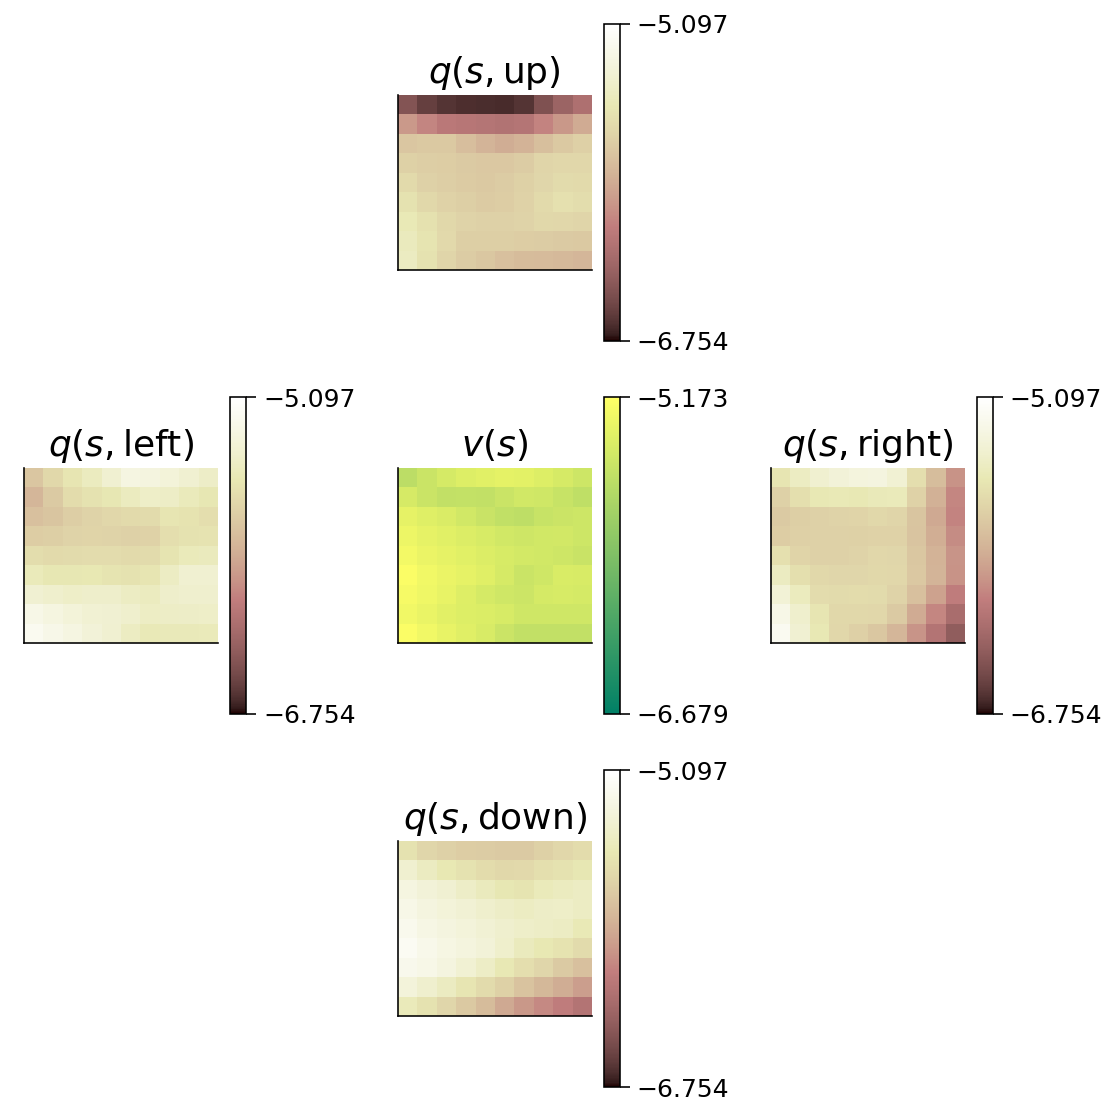

In [43]:
#@title Visualise the learned Q values { form-width: "30%" }

# Evaluate the policy for every state, similar to tabular agents above.

environment.reset()
pi = np.zeros(grid._layout_dims, dtype=np.int32)
q = np.zeros(grid._layout_dims + (4,))
for y in range(grid._layout_dims[0]):
  for x in range(grid._layout_dims[1]):
    # Hack observation to see what the Q-network would output at that point.
    environment.set_state(x, y)
    obs = environment.get_obs()
    q[y, x] = np.asarray(agent.q_values(obs))
    pi[y, x] = np.asarray(agent.select_action(obs))

plot_action_values(q)

### Compare the greedy and behaviour ($\epsilon$-greedy) policies

Notice that the behaviour policy randomly flips arrows to random directions.

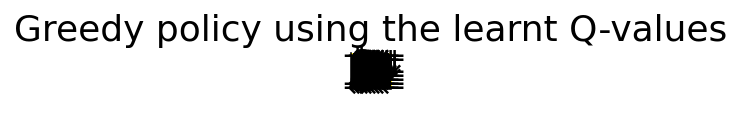

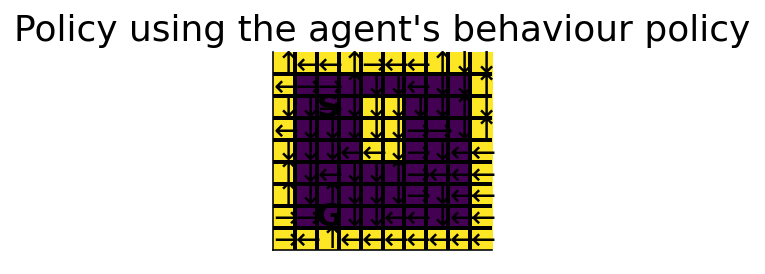

In [44]:
environment.plot_greedy_policy(q)
plt.title('Greedy policy using the learnt Q-values')

environment.plot_policy(pi)
plt.title("Policy using the agent's behaviour policy");

---
# Section 7: DQN

Video available at https://youtu.be/WI0UBxkz3oI


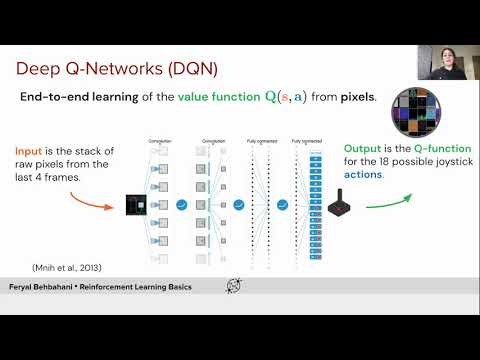

In [45]:
#@title Video 10: Deep Q-Networks (DQN)
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="WI0UBxkz3oI", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


<!-- <center><img src="https://drive.google.com/uc?id=1ivTQBHWkYi_J9vWwXFd2sSWg5f2TB5T-" width="500" /></center>  -->

<center><img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnature14236/MediaObjects/41586_2015_Article_BFnature14236_Fig1_HTML.jpg" width="500" /></center> 

In this section, we will look at an advanced deep RL Agent based on the following publication, [Playing Atari with Deep Reinforcement Learning](https://deepmind.com/research/publications/playing-atari-deep-reinforcement-learning), which introduced the first deep learning model to successfully learn control policies directly from high-dimensional pixel inputs using RL.

Here the agent will act directly on a pixel representation of the gridworld. You can find an incomplete implementation below.



Video available at https://youtu.be/HMbRdbKMI_Y


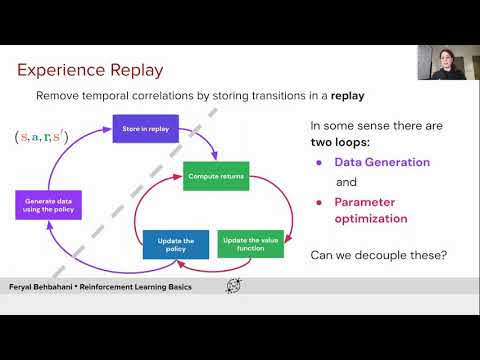

In [46]:
#@title Video 11: DQN and Experience Replay
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="HMbRdbKMI_Y", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

### Coding Exercise 7.1: Run a DQN Agent 


In [47]:
class DQN(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               network: nn.Module,
               replay_capacity: int = 100_000,
               epsilon: float = 0.1,
               batch_size: int = 1,
               learning_rate: float = 5e-4,
               target_update_frequency: int = 10):

    # Store agent hyperparameters and network.
    self._num_actions = environment_spec.actions.num_values
    self._epsilon = epsilon
    self._batch_size = batch_size
    self._q_network = q_network
    self._target_network = copy.deepcopy(self._q_network)
    # Container for the computed loss (see run_loop implementation above).
    self.last_loss = 0.0

    # Create the replay buffer.
    self._replay_buffer = ReplayBuffer(replay_capacity)
    # Keep an internal tracker of steps
    self._current_step = 0

    # How often to update the target network
    self._target_update_frequency = target_update_frequency
    # Setup optimizer that will train the network to minimize the loss.
    self._optimizer = torch.optim.Adam(self._q_network.parameters(),lr = learning_rate)
    self._loss_fn = nn.MSELoss()

  def select_action(self, observation):
    # Compute Q-values.
    # Sonnet requires a batch dimension, which we squeeze out right after.
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))  # Adds batch dimension.
    q_values = q_values.squeeze(0)   # Removes batch dimension

    # Select epsilon-greedy action.
    if self._epsilon < torch.rand(1):
      action = q_values.argmax(axis=-1)
    else:
      action = torch.randint(low=0, high=self._num_actions , size=(1,), dtype=torch.int64)
    return action

  def q_values(self, observation):
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))
    return q_values.squeeze(0).detach()

  def update(self):
    self._current_step += 1

    if not self._replay_buffer.is_ready(self._batch_size):
      # If the replay buffer is not ready to sample from, do nothing.
      return

    # Sample a minibatch of transitions from experience replay.
    transitions = self._replay_buffer.sample(self._batch_size)

    # Optionally unpack the transitions to lighten notation.
    # Note: each of these tensors will be of shape [batch_size, ...].
    s = torch.tensor(transitions.state)
    a = torch.tensor(transitions.action,dtype=torch.int64)
    r = torch.tensor(transitions.reward)
    d = torch.tensor(transitions.discount)
    next_s = torch.tensor(transitions.next_state)

    # Compute the Q-values at next states in the transitions.
    with torch.no_grad():
      #################################################
      # Fill in missing code below (...),
      # then remove or comment the line below to test your implementation
      raise NotImplementedError("Student exercise: complete the DQN Agent")
      #################################################
      #TODO get the value of the next states evaluated by the target network
      q_next_s = ...  # Shape [batch_size, num_actions].
      max_q_next_s = q_next_s.max(axis=-1)[0]
      # Compute the TD error and then the losses.
      # TODO compute the target value
      target_q_value = ...

    # Compute the Q-values at original state.
    q_s = self._q_network(s)

    # Gather the Q-value corresponding to each action in the batch.
    q_s_a = q_s.gather(1, a.view(-1,1)).squeeze(0)
    # Compute the TD errors.
    #td_error = target_q_value - q_s_a

    # Average the squared TD errors over the entire batch (axis=0).
    loss = self._loss_fn(target_q_value, q_s_a)

    # Compute the gradients of the loss with respect to the q_network variables.
    self._optimizer.zero_grad()

    loss.backward()
    # Apply the gradient update.
    self._optimizer.step()

    if self._current_step % self._target_update_frequency == 0:
      self._target_network.load_state_dict(self._q_network.state_dict())
    # Store the loss for logging purposes (see run_loop implementation above).
    self.last_loss = loss.detach().numpy()

  def observe_first(self, timestep: dm_env.TimeStep):
    self._replay_buffer.add_first(timestep)

  def observe(self, action: int, next_timestep: dm_env.TimeStep):
    self._replay_buffer.add(action, next_timestep)


# Create a convenient container for the SARS tuples required by NFQ.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])

In [48]:
#to_remove solution
class DQN(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               network: nn.Module,
               replay_capacity: int = 100_000,
               epsilon: float = 0.1,
               batch_size: int = 1,
               learning_rate: float = 5e-4,
               target_update_frequency: int = 10):

    # Store agent hyperparameters and network.
    self._num_actions = environment_spec.actions.num_values
    self._epsilon = epsilon
    self._batch_size = batch_size
    self._q_network = q_network
    self._target_network = copy.deepcopy(self._q_network)
    # Container for the computed loss (see run_loop implementation above).
    self.last_loss = 0.0

    # Create the replay buffer.
    self._replay_buffer = ReplayBuffer(replay_capacity)
    # Keep an internal tracker of steps
    self._current_step = 0

    # How often to update the target network
    self._target_update_frequency = target_update_frequency
    # Setup optimizer that will train the network to minimize the loss.
    self._optimizer = torch.optim.Adam(self._q_network.parameters(),lr = learning_rate)
    self._loss_fn = nn.MSELoss()

  def select_action(self, observation):
    # Compute Q-values.
    # Sonnet requires a batch dimension, which we squeeze out right after.
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))  # Adds batch dimension.
    q_values = q_values.squeeze(0)   # Removes batch dimension

    # Select epsilon-greedy action.
    if self._epsilon < torch.rand(1):
      action = q_values.argmax(axis=-1)
    else:
      action = torch.randint(low=0, high=self._num_actions , size=(1,), dtype=torch.int64)
    return action

  def q_values(self, observation):
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))
    return q_values.squeeze(0).detach()

  def update(self):
    self._current_step += 1

    if not self._replay_buffer.is_ready(self._batch_size):
      # If the replay buffer is not ready to sample from, do nothing.
      return

    # Sample a minibatch of transitions from experience replay.
    transitions = self._replay_buffer.sample(self._batch_size)

    # Optionally unpack the transitions to lighten notation.
    # Note: each of these tensors will be of shape [batch_size, ...].
    s = torch.tensor(transitions.state)
    a = torch.tensor(transitions.action,dtype=torch.int64)
    r = torch.tensor(transitions.reward)
    d = torch.tensor(transitions.discount)
    next_s = torch.tensor(transitions.next_state)

    # Compute the Q-values at next states in the transitions.
    with torch.no_grad():
      # TODO get the value of the next states evaluated by the target network
      q_next_s = self._target_network(next_s)  # Shape [batch_size, num_actions].
      max_q_next_s = q_next_s.max(axis=-1)[0]
      # Compute the TD error and then the losses.
      # TODO compute the target value
      target_q_value = r + d * max_q_next_s

    # Compute the Q-values at original state.
    q_s = self._q_network(s)

    # Gather the Q-value corresponding to each action in the batch.
    q_s_a = q_s.gather(1, a.view(-1,1)).squeeze(0)
    # Compute the TD errors.
    #td_error = target_q_value - q_s_a

    # Average the squared TD errors over the entire batch (axis=0).
    loss = self._loss_fn(target_q_value, q_s_a)

    # Compute the gradients of the loss with respect to the q_network variables.
    self._optimizer.zero_grad()

    loss.backward()
    # Apply the gradient update.
    self._optimizer.step()

    if self._current_step % self._target_update_frequency == 0:
      self._target_network.load_state_dict(self._q_network.state_dict())
    # Store the loss for logging purposes (see run_loop implementation above).
    self.last_loss = loss.detach().numpy()

  def observe_first(self, timestep: dm_env.TimeStep):
    self._replay_buffer.add_first(timestep)

  def observe(self, action: int, next_timestep: dm_env.TimeStep):
    self._replay_buffer.add(action, next_timestep)


# Create a convenient container for the SARS tuples required by NFQ.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])

In [49]:
#@title Train and evaluate the DQN agent { form-width: "30%" }
epsilon = 0.25  # @param {type: "number"}


grid = build_gridworld_task(
    task='simple',
    observation_type=ObservationType.GRID,
    max_episode_length=200)
environment, environment_spec = setup_environment(grid)

# Build the agent's network.
class Permute(nn.Module):
  def __init__(self, order: list):
    super(Permute,self).__init__()
    self.order = order

  def forward(self, x):
    return x.permute(self.order)

q_network = nn.Sequential(Permute([0, 3, 1, 2]),
                          nn.Conv2d(3, 32, kernel_size=4, stride=2,padding=1),
                          nn.ReLU(),
                          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                          nn.ReLU(),
                          nn.MaxPool2d(3, 1),
                          nn.Flatten(),
                          nn.Linear(384, 50),
                          nn.ReLU(),
                          nn.Linear(50, environment_spec.actions.num_values)
                          )

agent = DQN(
    environment_spec=environment_spec,
    network=q_network,
    batch_size=10,
    epsilon=epsilon,
    target_update_frequency=25)

returns = run_loop(
    environment=environment,
    agent=agent,
    num_episodes=1000,
    num_steps=100_000)

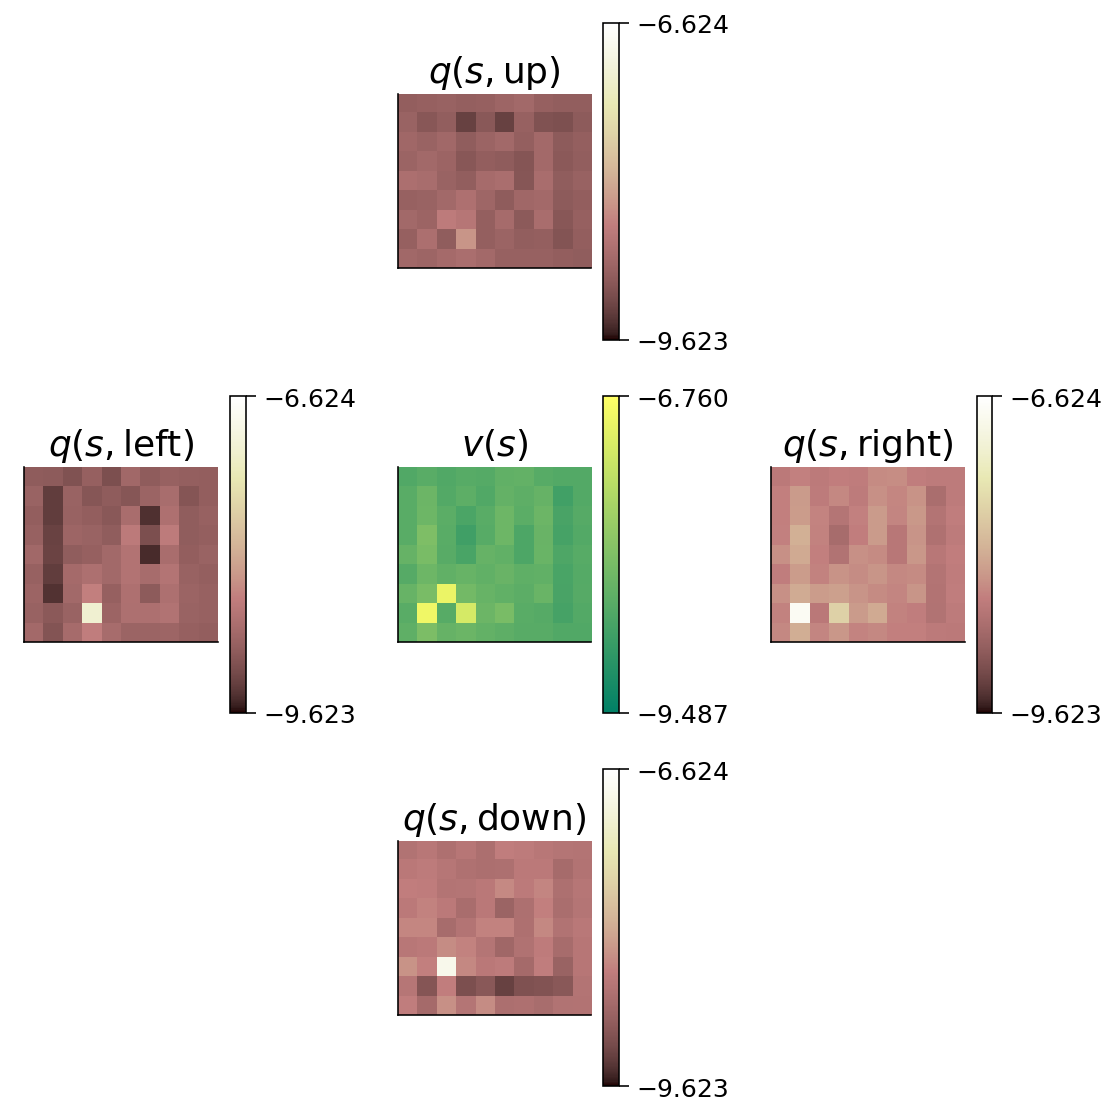

In [50]:
# @title Visualise the learned Q values  { form-width: "30%" }
# Evaluate the policy for every state, similar to tabular agents above.
pi = np.zeros(grid._layout_dims, dtype=np.int32)
q = np.zeros(grid._layout_dims + (4,))
for y in range(grid._layout_dims[0]):
  for x in range(grid._layout_dims[1]):
    # Hack observation to see what the Q-network would output at that point.
    environment.set_state(x, y)
    obs = environment.get_obs()
    q[y, x] = np.asarray(agent.q_values(obs))
    pi[y, x] = np.asarray(agent.select_action(obs))

plot_action_values(q)

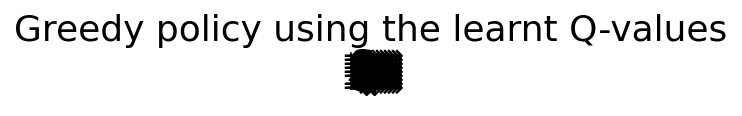

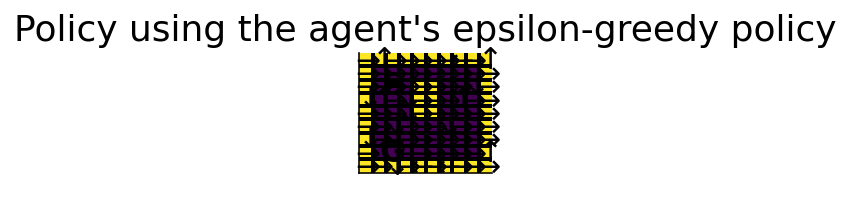

In [51]:
#@title Compare the greedy policy with the agent's policy { form-width: "30%" }

environment.plot_greedy_policy(q)
plt.title('Greedy policy using the learnt Q-values')

environment.plot_policy(pi)
plt.title("Policy using the agent's epsilon-greedy policy");

Video available at https://youtu.be/8O6jeElhQ_Y


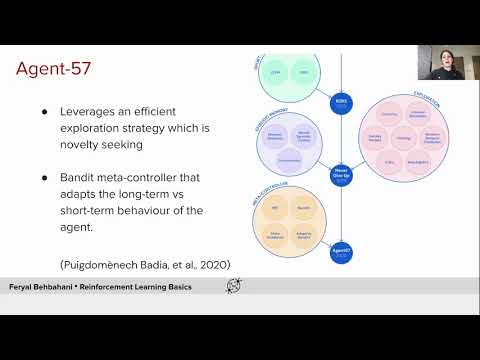

In [52]:
#@title Video 12: DQN Algorithms
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="8O6jeElhQ_Y", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---
# Section 8: Beyond Value Based Model-Free Methods

In [53]:
#@title Video 13: Other RL Methods
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/


In [54]:
# Tune hyperparameters
SEED=2021
learning_rate = 0.01
gamma = 0.99
dropout = 0.6

# hyperparameters
hidden_neurons = 128 # Only used in Policy Gradient Method
hidden_size = 256 # only used in Actor-Critic Method

num_steps = 300
max_episodes = 1000

In [55]:
# Use the CartPole example
env = gym.make('CartPole-v1')

# Set seeds
env.seed(SEED)
set_seed(SEED)

Random seed 2021 has been set.


## Section 8.1: Policy gradient

Now we will turn to policy gradient methods. Rather than defining the policy in terms of a value function, i.e. $\color{blue}\pi(\color{red}s) = \arg\max_{\color{blue}a}\color{green}Q(\color{red}s, \color{blue}a)$, we will directly parameterize the policy and write it as the distribution

$$\color{blue}a_t \sim \color{blue}\pi_{\theta}(\color{blue}a_t|\color{red}s_t).$$

Here $\theta$ represent the parameters of the policy. We will update the policy parameters using gradient ascent to **maximize** expected future reward.

One convenient way to represent the conditional distribution above is as a function that takes a state $\color{red}s$ and returns a distribution over actions $\color{blue}a$.

Defined below is an agent which implements the REINFORCE algorithm. 
REINFORCE (Williams 1992) is the simplest model-free general reinforcement learning technique.

The **basic idea** is to use probabilistic action choice. If the reward at the end turns out to be high, we make **all** actions in this sequence **more likely** (otherwise, we do the opposite).

This may sometimes reinforce "bad" actions as well, but they will hence turn out to be part of trajectories with low reward and will likely not get accentuated.

From the lectures, we know that we need to compute

$$
\nabla J(\theta) 
= \mathbb{E}
\left[
  \sum_{t=0}^T \color{green} G_t 
  \nabla\log\color{blue}\pi_\theta(\color{red}{s_t})
\right]
$$

where $\color{green} G_t$ is the sum over future rewards from time $t$, defined as

$$
\color{green} G_t 
= \sum_{n=t}^T \gamma^{n-t} 
\color{green} R(\color{red}{s_t}, \color{blue}{a_t}, \color{red}{s_{t+1}}).
$$

**insert a pictorial slide from the slide deck**

The algorithm below will collect the state, action, and reward data in its buffer until it reaches a full trajectory. It will then update its policy given the above gradient (and the Adam optimizer).

A policy gradient trains an agent without explicitly mapping the value for every state-action pair in an environment by taking small steps and updating the policy based on the reward associated with that step. In this section, we will build a small network that trains using policy gradient using PyTorch.

The agent can receive a reward immediately for an action or the agent can receive the award at a later time such as the end of the episode. 

The policy function for our agent will try to learn as $\pi_\theta(a,s)$, where $\theta$ is the parameter vector, $s$ is a particular state, and $a$ is an action.

Monte-Carlo Policy Gradient approach will be used, which means the agent will run through an entire episode and then update policy based on the rewards obtained.

### Coding Exercise 8.1: Creating a simple neural network

Below you will find some incomplete code. Fill in the missing code to construct the specified neural network.

Let us define a simple feed forward neural network with one hidden layer of 128 neurons and a dropout of 0.6. Let's use Adam as our optimizer and a learning rate of 0.01. Use the hyperparameters already defined rather than using explicit values.

Using dropout will significantly improve the performance of the policy. Do compare your results with and without dropout and experiment with other hyper-parameter values as well.

In [56]:
class PolicyGradientNet(nn.Module):
  def __init__(self):
    super(PolicyGradientNet, self).__init__()
    self.state_space = env.observation_space.shape[0]
    self.action_space = env.action_space.n
    #################################################
    ## TODO for students: fill in the missing code
    ## from the first expression
    raise NotImplementedError("Student exercise: Create FF neural network.")
    #################################################
    self.l1 = ...
    self.l2 = ...
    self.gamma = ...
    # Episode policy and past rewards
    self.past_policy = Variable(torch.Tensor())
    self.reward_episode = []
    # Overall reward and past loss
    self.past_reward = []
    self.past_loss = []

  def forward(self, x):
    model = torch.nn.Sequential(
        self.l1,
        nn.Dropout(p=dropout),
        nn.ReLU(),
        self.l2,
        nn.Softmax(dim=-1)
    )
    return model(x)

In [57]:
#to_remove solution
class PolicyGradientNet(nn.Module):
  def __init__(self):
    super(PolicyGradientNet, self).__init__()
    self.state_space = env.observation_space.shape[0]
    self.action_space = env.action_space.n
    self.l1 = nn.Linear(self.state_space, hidden_neurons, bias=False)
    self.l2 = nn.Linear(hidden_neurons, self.action_space, bias=False)
    self.gamma = gamma
    # Episode policy and past rewards
    self.past_policy = Variable(torch.Tensor())
    self.reward_episode = []
    # Overall reward and past loss
    self.past_reward = []
    self.past_loss = []

  def forward(self, x):
    model = torch.nn.Sequential(
        self.l1,
        nn.Dropout(p=dropout),
        nn.ReLU(),
        self.l2,
        nn.Softmax(dim=-1)
    )
    return model(x)

Now let's create an instance of the network we have defined and use ADAM as the optimizer using the learning_rate as hyperparameter already defined above.

In [58]:
policy = PolicyGradientNet()
pg_optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

### Select Action

The `select_action()` function chooses an action based on our policy probability distribution using the PyTorch distributions package.  Our policy returns a probability for each possible action in our action space (move left or move right) as an array of length two such as [0.7, 0.3].  We then choose an action based on these probabilities, record our history, and return our action. 

In [59]:
def select_action(state):
  #Select an action (0 or 1) by running policy model and choosing based on the probabilities in state
  state = torch.from_numpy(state).type(torch.FloatTensor)
  state = policy(Variable(state))
  c = Categorical(state)
  action = c.sample()

  # Add log probability of chosen action
  if policy.past_policy.dim() != 0:
    policy.past_policy = torch.cat([policy.past_policy, c.log_prob(action).reshape(1)])
  else:
    policy.past_policy = (c.log_prob(action).reshape(1))
  return action

### Update policy

This function updates the policy.

### Reward $G_t$
We update our policy by taking a sample of the action value function $Q^{\pi_\theta} (s_t,a_t)$ by playing through episodes of the game.  $Q^{\pi_\theta} (s_t,a_t)$ is defined as the expected return by taking action $a$ in state $s$ following policy $\pi$.

We know that for every step the simulation continues we receive a reward of 1.  We can use this to calculate the policy gradient at each time step, where $r$ is the reward for a particular state-action pair.  Rather than using the instantaneous reward, $r$, we instead use a long term reward $ v_{t} $ where $v_t$ is the discounted sum of all future rewards for the length of the episode.   $v_{t}$ is then,

$$
\color{green} G_t 
= \sum_{n=t}^T \gamma^{n-t} 
\color{green} R(\color{red}{s_t}, \color{blue}{a_t}, \color{red}{s_{t+1}}).
$$

where $\gamma$ is the discount factor (0.99).  For example, if an episode lasts 5 steps, the reward for each step will be [4.90, 3.94, 2.97, 1.99, 1].
Next we scale our reward vector by substracting the mean from each element and scaling to unit variance by dividing by the standard deviation.  This practice is common for machine learning applications and the same operation as Scikit Learn's __[StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)__.  It also has the effect of compensating for future uncertainty.

## Update Policy
After each episode we apply Monte-Carlo Policy Gradient to improve our policy according to the equation:

$$\Delta\theta_t = \alpha\nabla_\theta \, \log \pi_\theta (s_t,a_t)G_t  $$

We will then feed our policy history multiplied by our rewards to our optimizer and update the weights of our neural network using stochastic gradient **ascent**.  This should increase the likelihood of actions that got our agent a larger reward.

### Exercise 8.2: Update network weights while updating the overall policy

Below you will find some incomplete code. Fill in the missing code to construct the specified neural network.



In [60]:
def update_policy():
  R = 0
  rewards = []

  # Discount future rewards back to the present using gamma
  for r in policy.reward_episode[::-1]:
    R = r + policy.gamma * R
    rewards.insert(0, R)

  # Scale rewards
  rewards = torch.FloatTensor(rewards)
  rewards = (rewards - rewards.mean()) / (rewards.std() +
                                          np.finfo(np.float32).eps)

  # Calculate loss
  pg_loss = (torch.sum(torch.mul(policy.past_policy,
                              Variable(rewards)).mul(-1), -1))
  #################################################
  ## TODO for students: fill in the missing code
  ## from the first expression
  raise NotImplementedError("Student exercise: Update the network weights.")
  #################################################
  # Update network weights
  # Use zero_grad(), backward() and step() methods of the optimizer instance.
  pg_optimizer.zero_grad()
  pg_loss.backward()
  # Update the weights
  for param in policy.parameters():
      param.grad.data.clamp_(-1, 1)
  pg_optimizer.step()

  # Save and intialize episode past counters
  policy.past_loss.append(pg_loss.item())
  policy.past_reward.append(np.sum(policy.reward_episode))
  policy.past_policy = Variable(torch.Tensor())
  policy.reward_episode= []

In [61]:
#to_remove solution
def update_policy():
  R = 0
  rewards = []

  # Discount future rewards back to the present using gamma
  for r in policy.reward_episode[::-1]:
    R = r + policy.gamma * R
    rewards.insert(0, R)

  # Scale rewards
  rewards = torch.FloatTensor(rewards)
  rewards = (rewards - rewards.mean()) / (rewards.std() +
                                          np.finfo(np.float32).eps)

  # Calculate loss
  pg_loss = (torch.sum(torch.mul(policy.past_policy,
                              Variable(rewards)).mul(-1), -1))

  # Update network weights
  # Use zero_grad(), backward() and step() methods of the optimizer instance.
  pg_optimizer.zero_grad()
  pg_loss.backward()
  # Update the weights
  for param in policy.parameters():
      param.grad.data.clamp_(-1, 1)
  pg_optimizer.step()

  # Save and intialize episode past counters
  policy.past_loss.append(pg_loss.item())
  policy.past_reward.append(np.sum(policy.reward_episode))
  policy.past_policy = Variable(torch.Tensor())
  policy.reward_episode= []

### Training
This is our main policy training loop.  For each step in a training episode, we choose an action, take a step through the environment, and record the resulting new state and reward.  We call update_policy() at the end of each episode to feed the episode history to our neural network and improve our policy.

In [62]:
def policy_gradient_train(episodes):
  running_reward = 10
  for episode in range(episodes):
    state = env.reset()
    done = False

    for time in range(1000):
      action = select_action(state)
      # Step through environment using chosen action
      state, reward, done, _ = env.step(action.item())

      # Save reward
      policy.reward_episode.append(reward)
      if done:
        break

    # Used to determine when the environment is solved.
    running_reward = (running_reward * gamma) + (time * (1 - gamma))

    update_policy()

    if episode % 50 == 0:
      print(f"Episode {episode}\tLast length: {time:5.0f}"
            f"\tAverage length: {running_reward:.2f}")

    if running_reward > env.spec.reward_threshold:
      print(f"Solved! Running reward is now {running_reward} "
            f"and the last episode runs to {time} time steps!")
      break

### Run the model

In [63]:
episodes = 1000
policy_gradient_train(episodes)

Episode 0	Last length:    12	Average length: 10.02
Episode 50	Last length:   394	Average length: 40.32
Episode 100	Last length:   499	Average length: 119.80
Episode 150	Last length:   120	Average length: 189.57
Episode 200	Last length:   300	Average length: 289.90
Episode 250	Last length:   499	Average length: 272.67
Episode 300	Last length:   182	Average length: 329.58
Episode 350	Last length:   276	Average length: 359.89
Episode 400	Last length:   499	Average length: 401.58
Episode 450	Last length:   499	Average length: 412.60
Episode 500	Last length:   499	Average length: 415.03
Episode 550	Last length:   441	Average length: 380.77
Episode 600	Last length:   275	Average length: 407.22
Episode 650	Last length:   431	Average length: 402.56
Episode 700	Last length:   290	Average length: 420.28
Episode 750	Last length:   499	Average length: 410.84
Episode 800	Last length:   428	Average length: 437.24
Episode 850	Last length:   499	Average length: 455.22
Episode 900	Last length:   284	Av

### Plot the results

In [64]:
#@title Helper function for plotting the training performance

def plot_policy_gradient_training():
  window = int(episodes / 20)

  fig, ((ax1), (ax2)) = plt.subplots(1, 2, sharey=True, figsize=[15, 4]);
  rolling_mean = pd.Series(policy.past_reward).rolling(window).mean()
  std = pd.Series(policy.past_reward).rolling(window).std()
  ax1.plot(rolling_mean)
  ax1.fill_between(range(len(policy.past_reward)),
                   rolling_mean-std, rolling_mean+std,
                   color='orange', alpha=0.2)
  ax1.set_title(f"Episode Length Moving Average ({window}-episode window)")
  ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode Length')

  ax2.plot(policy.past_reward)
  ax2.set_title('Episode Length')
  ax2.set_xlabel('Episode')
  ax2.set_ylabel('Episode Length')

  fig.tight_layout(pad=2)
  plt.show()

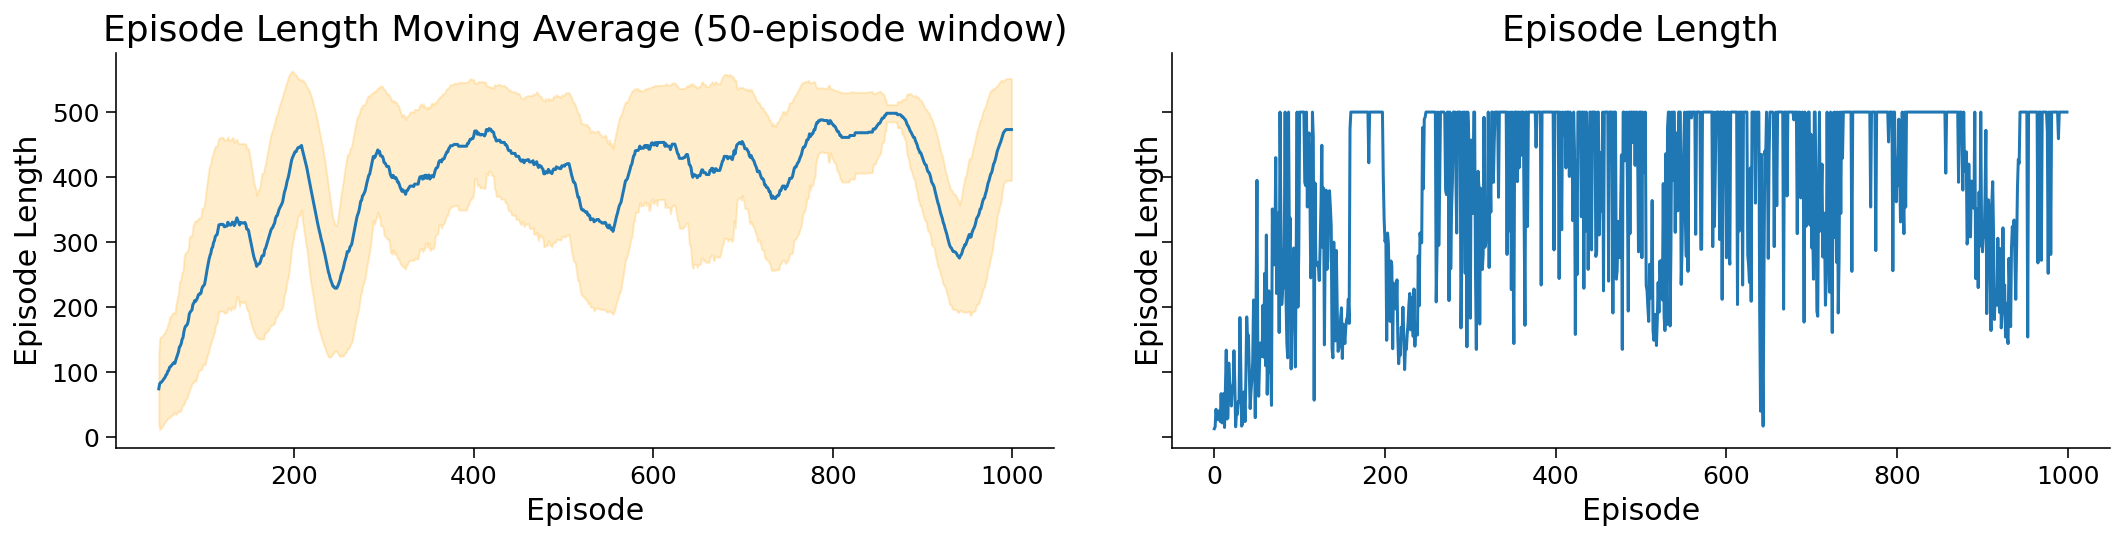

In [65]:
plot_policy_gradient_training()

### Exercise 8.3: BONUS

Try running the model again, by modifying the hyperparameters and observe the outputs.

What do you see when you 

1. increase learning rate
2. decrease learning rate
3. decrease gamma
4. increase number of neurons in the network.

## Section 8.2: Actor-critic

Recall the policy gradient

$$
\nabla J(\theta) 
= \mathbb{E}
\left[
  \sum_{t=0}^T \color{green} G_t 
  \nabla\log\color{blue}\pi_\theta(\color{red}{s_t})
\right]
$$

The policy parameters are updated using Monte Carlo technique and uses random samples. This introduces high variability in log probabilities and cumulative reward values. This leads to noisy gradients and can cause unstable learning.

One way to reduce variance and increase stability is subtracting the cumulative reward by a baseline:

$$
\nabla J(\theta) 
= \mathbb{E}
\left[
   \sum_{t=0}^T \color{green} (G_t  - b)
  \nabla\log\color{blue}\pi_\theta(\color{red}{s_t})
\right]
$$

Intuitively, reducing cumulative reward will make smaller gradients and thus smaller and more stable (hopefully) updates.

From the lecture slides, we know that in Actor Critic Method:
1. The “Critic” estimates the value function. This could be the action-value (the Q value) or state-value (the V value).
2. The “Actor” updates the policy distribution in the direction suggested by the Critic (such as with policy gradients).

Both the Critic and Actor functions are parameterized with neural networks. The "Critic" network parameterizes the Q-value.

### Actor Critic Network

In [66]:
class ActorCriticNet(nn.Module):
  def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
    super(ActorCriticNet, self).__init__()

    self.num_actions = num_actions
    self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
    self.critic_linear2 = nn.Linear(hidden_size, 1)

    self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
    self.actor_linear2 = nn.Linear(hidden_size, num_actions)

    self.all_rewards = []
    self.all_lengths = []
    self.average_lengths = []

  def forward(self, state):
    state = Variable(torch.from_numpy(state).float().unsqueeze(0))
    value = F.relu(self.critic_linear1(state))
    value = self.critic_linear2(value)

    policy_dist = F.relu(self.actor_linear1(state))
    policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

    return value, policy_dist

### Training

In [67]:
def actor_critic_train(episodes):
  all_lengths = []
  average_lengths = []
  all_rewards = []
  entropy_term = 0

  for episode in range(episodes):
    log_probs = []
    values = []
    rewards = []

    state = env.reset()
    for steps in range(num_steps):
      value, policy_dist = actor_critic.forward(state)
      value = value.detach().numpy()[0, 0]
      dist = policy_dist.detach().numpy()

      action = np.random.choice(num_outputs, p=np.squeeze(dist))
      log_prob = torch.log(policy_dist.squeeze(0)[action])
      entropy = -np.sum(np.mean(dist) * np.log(dist))
      new_state, reward, done, _ = env.step(action)

      rewards.append(reward)
      values.append(value)
      log_probs.append(log_prob)
      entropy_term += entropy
      state = new_state

      if done or steps == num_steps - 1:
        qval, _ = actor_critic.forward(new_state)
        qval = qval.detach().numpy()[0, 0]
        all_rewards.append(np.sum(rewards))
        all_lengths.append(steps)
        average_lengths.append(np.mean(all_lengths[-10:]))
        if episode % 50 == 0:
          print(f"episode: {episode},\treward: {np.sum(rewards)},"
                f"\ttotal length: {steps},"
                f"\taverage length: {average_lengths[-1]}")
        break

    # compute Q values
    qvals = np.zeros_like(values)
    for t in reversed(range(len(rewards))):
      qval = rewards[t] + gamma * qval
      qvals[t] = qval

    #update actor critic
    values = torch.FloatTensor(values)
    qvals = torch.FloatTensor(qvals)
    log_probs = torch.stack(log_probs)

    advantage = qvals - values
    actor_loss = (-log_probs * advantage).mean()
    critic_loss = 0.5 * advantage.pow(2).mean()
    ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

    ac_optimizer.zero_grad()
    ac_loss.backward()
    ac_optimizer.step()

  # Store results
  actor_critic.average_lengths = average_lengths
  actor_critic.all_rewards = all_rewards
  actor_critic.all_lengths = all_lengths

### Run the model

In [68]:
env.reset()

num_inputs = env.observation_space.shape[0]
num_outputs = env.action_space.n

actor_critic = ActorCriticNet(num_inputs, num_outputs, hidden_size)
ac_optimizer = optim.Adam(actor_critic.parameters())

actor_critic_train(500)

episode: 0,	reward: 19.0,	total length: 18,	average length: 18.0
episode: 50,	reward: 13.0,	total length: 12,	average length: 19.1
episode: 100,	reward: 20.0,	total length: 19,	average length: 30.7
episode: 150,	reward: 21.0,	total length: 20,	average length: 28.3
episode: 200,	reward: 57.0,	total length: 56,	average length: 67.5
episode: 250,	reward: 107.0,	total length: 106,	average length: 73.1
episode: 300,	reward: 115.0,	total length: 114,	average length: 125.6
episode: 350,	reward: 140.0,	total length: 139,	average length: 123.6
episode: 400,	reward: 124.0,	total length: 123,	average length: 96.0
episode: 450,	reward: 125.0,	total length: 124,	average length: 168.7


### Plot the results

In [69]:
#@title Helper function for plotting training performance
def plot_actor_critic_training():
  window = int(episodes / 20)

  plt.figure(figsize=(15, 4))
  plt.subplot(1, 2, 1)

  smoothed_rewards = pd.Series(actor_critic.all_rewards).rolling(window).mean()
  std = pd.Series(actor_critic.all_rewards).rolling(window).std()

  plt.plot(smoothed_rewards, label='Smoothed rewards')
  plt.fill_between(range(len(smoothed_rewards)),
                   smoothed_rewards-std, smoothed_rewards+std,
                   color='orange', alpha=0.2)

  plt.xlabel('Episode')
  plt.ylabel('Reward')

  plt.subplot(1, 2, 2)
  plt.plot(actor_critic.all_lengths, label='All lengths')
  plt.plot(actor_critic.average_lengths, label='Average lengths')
  plt.xlabel('Episode')
  plt.ylabel('Episode length')
  plt.legend()

  plt.tight_layout()

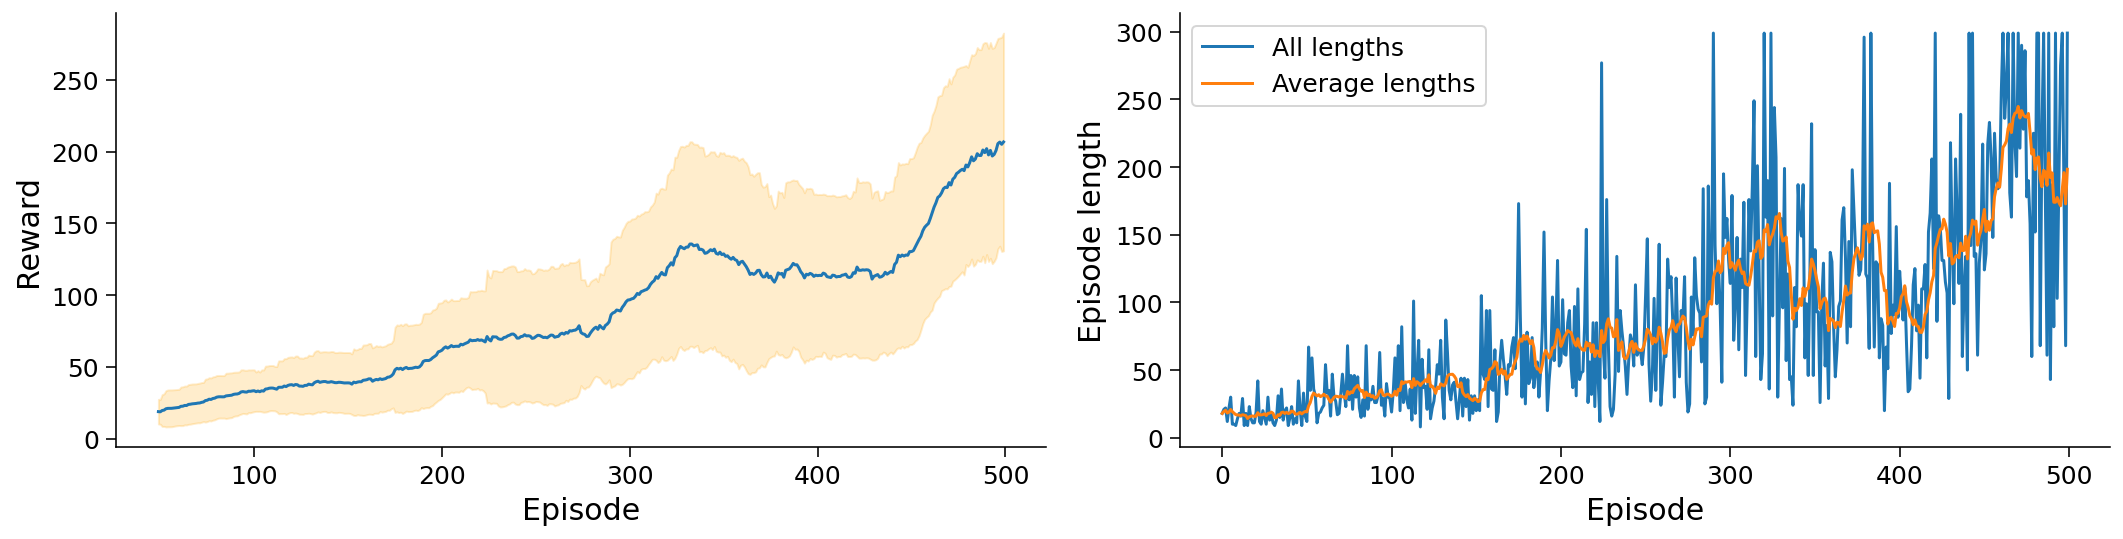

In [70]:
plot_actor_critic_training()

### Exercise 8.4: Effect of episodes on performance

Change the episodes from 500 to 3000 and observe the performance impact.

### Exercise 8.5: Effect of learning rate on performance

Modify the hyperparameters related to learning_rate and gamma and observe the impact on the performance.

---
#Section 9: RL in the real world

Video available at https://youtu.be/5kBtiW88QVw


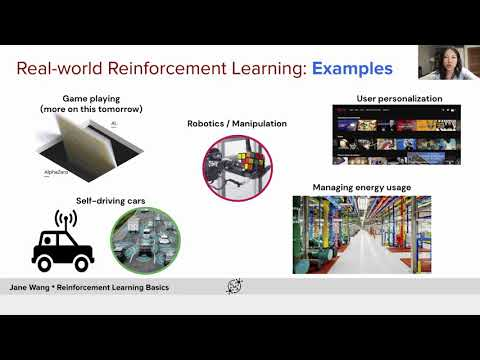

In [71]:
#@title Video 14: Real-world applications and ethics
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="5kBtiW88QVw", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

### Exercise 9.1: Group discussion

Form a group of 2-3 and have discussions (roughly 3 minutes each) of the following questions:

1. **Safety**: what are some safety issues that arise in RL that don’t arise with e.g. supervised learning?

2. **Generalization**: What happens if your RL agent is presented with data it hasn’t trained on? (“goes out of distribution”)

3. How important do you think **interpretability** is in the ethical and safe deployment of RL agents in the real world? 


---
#Section 10: How to learn more

Video available at https://youtu.be/dKaOpgor5Ek


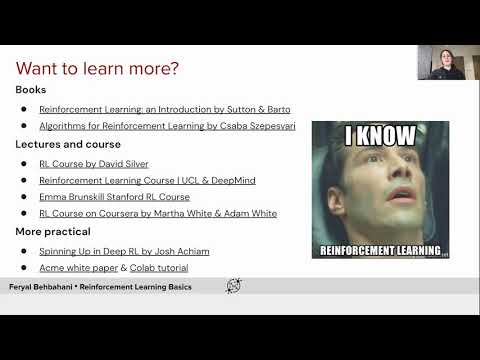

In [72]:
#@title Video 15: How to learn more
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="dKaOpgor5Ek", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---
#Appendix (directly from MLSS tut for now)
Books and lecture notes
*   [Reinforcement Learning: an Introduction by Sutton & Barto](http://incompleteideas.net/book/RLbook2018.pdf)
* [Algorithms for Reinforcement Learning by Csaba Szepesvari](https://sites.ualberta.ca/~szepesva/papers/RLAlgsInMDPs.pdf)

Lectures and course 
*   [RL Course by David Silver](https://www.youtube.com/playlist?list=PLzuuYNsE1EZAXYR4FJ75jcJseBmo4KQ9-)
*   [Reinforcement Learning Course | UCL & DeepMind](https://www.youtube.com/playlist?list=PLqYmG7hTraZBKeNJ-JE_eyJHZ7XgBoAyb)
*   [Emma Brunskill Stanford RL Course](https://www.youtube.com/playlist?list=PLoROMvodv4rOSOPzutgyCTapiGlY2Nd8u)
*   [RL Course on Coursera by Martha White & Adam White](https://www.coursera.org/specializations/reinforcement-learning)

More practical:
* [Spinning Up in Deep RL by Josh Achiam](https://spinningup.openai.com/en/latest/)
*   [Acme white paper](http://go/arxiv/2006.00979) & [Colab tutorial](https://github.com/deepmind/acme/blob/master/examples/tutorial.ipynb)

<br>

This Colab is based on the [EEML 2020 RL practical](https://colab.research.google.com/github/eemlcommunity/PracticalSessions2020/blob/master/rl/EEML2020_RL_Tutorial.ipynb) by Feryal Behbahani & Gheorghe Comanici. If you are interested in JAX you should try the colab :)
